In [5]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=80
plt.rcParams['figure.facecolor']='w'
#from scipy.optimize import curve_fit
#from scipy import stats
#from scipy.stats import norm
import math as m
import random as rd
import pandas as pd
from pandas import *

#### Important - THE shock arrival time for ICME 143(2014) is different in the WIND catalogue and the Bhattacharjee paper!

## About

1) The percentage deviation graphs now find mean percentage deviation from the average of the data from start to shock arrival time, not the entire duration of data considered. Exact calculation methods of dip sizes for both methods are explained in the cell below.

2) Implemented a station-based function for plotting. Helps get rid of incomplete data sets easily, and also allows data from other stations to be plotted and analysed for a particular ICME timeframe, even if one NM station data is dirty.

3) Plotting the minima detected as a vertical line, and the predip avg value as a horizontal line, for visual verification.

4) Finding FD magnitudes as (predi_avg - minima inside window) for both %deviation graphs as well as smoothed NM count direct plots. I've a hunch that the latter represents what I'm trying to do more accurately.

5) The predip_avg is now being calculated over 96 hours before the shock arrival. The full data for every station extends from 96 hours before the shock arrival to 120 hours after the MC end. 

6) A new check for net increases in NM counts has also been encoded to alert us of a "Forbush Increase", in the function named "allstation_analyze", defined below the "analyze" function in this notebook. Examples of these outlier events are in some stations' data of ICME 144(2014) and ICME 141(2014) (uncommented in the respective cells of these events)

7) 2 major functions in this notebook - 

    "analyze" plots the smoothed NM count and percentage deviation data for a single NM station (depending on the column number input). 
    
    "allstation_analyze" plots multiple subplots in the same environment for both kinds of data (depending on the input), Smoothed NM counts and %mean deviation, from all available NM stations (13 right now, listed before the function definition), for a single ICME event. Also plots the predip_avg, 3 timestamps (shock arrival, MC start, MC end) onto each subplot, and returns FD magnitude values. This allows us to view all available dip profiles in a single glance and makes quality characterization easier.

## Data analyis math - 

1. Time series data obtained from nmdb.eu/nest with 1-hour resolution, for different NM stations, for 11+ ICME events as identified in Debesh's paper, from the WIND catalogue. Window from 96 hours before the shock arrival time to 120 hours after MC end (more time here for scope to analyze recovery times in the future)

2. Trail Smoothed this time series data with a 12 hour window (trail smoothing apparently works better to amplify and showcase local trends in the data (such as the dips we want), compared to central smoothing). 
$$ \text{Smoothed_data}[i] = \text{ mean(11 data points before i} + i^\text{th} \text{data point}) $$

#### Working with counts/sec data - 

3. $$ \text{predip_avg (in counts/s)} = \text{mean(Smoothed_data}[ 0:\text{shock time}]) $$


4. $$ \text{Local minima} = \text{min(Smoothed_data}[\text{shock} : \text{mcend} + 12]) $$. 
      Index of this local minima value is also noted and plotted on the graphs, for a visual aid.


5. $$ \text{FD magnitude (absolute) (in counts/s)} = \text{predip_avg (in counts/s) - local minima (in count/s)} $$


6. $$ \text{FD magnitude (normalized) (dimensionless)} = \left(\frac{\text{Absolute FD magnitude (in counts/s)}}{\text{predip_avg (in counts/s)}}\right) $$


#### Working with %deviation - 

7. $$ \% \text{mean deviation}[i] = \left(\frac{\text{Smoothed_data}[i] - \text{predip_avg (in counts/s)}}{\text{predip_avg (in counts/s)}}\right) \times 100 $$


8. $$ \text{Smoothed_percentdev_data}[i] = \text{ mean(11 percentdev data points before i} + i^\text{th} \text{percentdev data point}) $$


9. $$ \text{percentdev_predip_avg (in %)} = \text{mean(Smoothed_percentdev_data}[ 0:\text{shock time}]) $$


10. $$ \text{Local minima_percentdev} = \text{min(Smoothed_percentdev_data}[shock : mcend + 12]) $$. 
      Index of this local minima value is also noted and plotted on the graphs, for a visual aid.
      

11. $$ \text{FD magnitude (% deviation) (in %)} = \text{percentdev_predip_avg (in %) - Local minima_percentdev (in %)} $$

In [6]:
def ind(array, item):
        for idx, val in np.ndenumerate(array):
            if val == item:
                return idx

In [7]:
# Making a function to plot individual station data (according to column number input) for 13 NM stations - 
# list of NM stations in order (column numbers in csv files) --->
# OULU, SNAE, APTY, FSMT, INVK, NAIN, PWNK, THUL, NEU3, SOPB, SOPO, MRNY, TERA

def analyze(filename, column, window, plot, plotname, shock, mcstart, mcend, lw):

    #### Reading data from csv
    df = read_csv(filename, delimiter=';',header=None)
    rawdata= df[column]
    time = np.array([i for i in range(0,len(df[column]))])
    
    #### Trailing rolling average 
    d = pd.Series(rawdata)
    mavg_trail_rawdata = d.rolling(window).mean()
    
    ### Arithmetic means of smoothed NM data from beginning to shock arrival to find % deviation from
    avg_rawdata_smooth = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ### Constructing % mean deviation arrays for each station using average values of smoothed data calculated
    percent_meandevi_rawdata    = np.empty(len(mavg_trail_rawdata))
    for i in range(0,len(mavg_trail_rawdata)):
        percent_meandevi_rawdata[i] = ((mavg_trail_rawdata[i] - avg_rawdata_smooth)/avg_rawdata_smooth)*100   
     
    ### Trail-Smoothening out % mean deviation data as well
    d = pd.Series(percent_meandevi_rawdata)
    mavg_trail_percent_meandevi_rawdata = d.rolling(window).mean()
    
    # Defining predip_avg NM count for smoothed count data from start to shock time
    predip_avg_count_rawdata = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time+12
    localmin_count_rawdata = np.min(mavg_trail_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_count_rawdata = ind(mavg_trail_rawdata, localmin_count_rawdata)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_count_rawdata = predip_avg_count_rawdata - localmin_count_rawdata
    
    ## Normalizing dipmag by dividing by predip_avg
    norm_dipmag_count = (dipmag_count_rawdata/predip_avg_count_rawdata)*100
    
    ## Defining predip average NM count as arithmetic mean of data from start to CME shock time
    predip_avg_rawdata = np.mean(mavg_trail_percent_meandevi_rawdata[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time
    localmin_rawdata = np.min(mavg_trail_percent_meandevi_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_rawdata = ind(mavg_trail_percent_meandevi_rawdata, localmin_rawdata)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_rawdata = predip_avg_rawdata - localmin_rawdata
    
    ## Normalizing dipmag by dividing by predip_avg
    norm_dipmag = dipmag_rawdata/predip_avg_rawdata
    
    
    if plot == "Smoothed":
        # 3 time stamps
        plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
        plt.axvline(mcstart, color='black', label='MC start')
        plt.axvline(mcend, color='black', linestyle='--', label="MC end")
        
        # 2 average values
        plt.axvline(minindex_count_rawdata, color='darkviolet', linestyle='-.', label="Minima")
        plt.axhline(predip_avg_count_rawdata, color='violet', linestyle=':', label='Predip Avg')
                
        # Cosmetics
        plt.style.use('seaborn')
        plt.title(plotname)
        
        if localmin_count_rawdata > predip_avg_count_rawdata:
            print ("Alert!! Forbush Increases lol!!!")
            
        else: 
            print("Seems good")
    
        # Plotting
        if column == 1:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'OULU-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='OULU-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
        
        elif column == 2:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'SNAE-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='SNAE-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 3:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'APTY-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='APTY-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
        
        elif column == 4:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'FSMT-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='FSMT-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 5:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'INVK-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='INVK-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 6:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'NAIN-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='NAIN-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 7:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'PWNK-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='PWNK-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 8:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'THUL-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='THUL-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 9:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'NEU3-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='NEU3-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
        
        elif column == 10:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'SOPB-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='SOPB-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 11:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'SOPO-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='SOPO-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 12:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'MRNY-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='MRNY-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
        elif column == 13:
            plt.plot(time, mavg_trail_rawdata, linewidth=lw, label= 'TERA-Trail-Smoothed' )
            #plt.plot(time, rawdata, linewidth=lw, label='TERA-1hr-data' )
            plt.xlabel("Time (hours)")
            plt.ylabel("Counts/s")
            plt.legend(loc=(1,0.65))
            plt.show()
            
         # Printing dipmag qtys
        print("Predip_avg = ", predip_avg_count_rawdata)
        print("Local minima = ", localmin_count_rawdata)
        print("FD magnitude = ", dipmag_count_rawdata)
        print("Normalized FDmag = ", norm_dipmag_count)
        print("Location of minima = ", minindex_count_rawdata)
       
        
    elif plot == "Percentdev_smooth":
                                
        # 3 time stamps
        plt.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
        plt.axvline(mcstart, color='black', label='MC start')
        plt.axvline(mcend, color='black', linestyle='--', label="MC end")
            
        # 2 average values
        plt.axvline(minindex_rawdata, color='darkviolet', linestyle='-.', label="Minima")
        plt.axhline(predip_avg_rawdata, color='violet', linestyle=':', label='Predip Avg')

        # Cosmetics
        plt.style.use('seaborn')
        plt.title(plotname)
        
        if localmin_rawdata > predip_avg_rawdata:
            print ("Alert!! Forbush Increases lol!!!")
            
        else: 
            print("Seems good")

        # Plotting
        if column == 1:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='OULU-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
        
        elif column == 2:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='SNAE-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 3:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='APTY-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 4:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='FSMT-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 5:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='INVK-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 6:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='NAIN-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 7:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='PWNK-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 8:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='THUL-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 9:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='NEU3-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 10:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='SOPB-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 11:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='SOPO-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 12:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='MRNY-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        elif column == 13:
            plt.plot(time, mavg_trail_percent_meandevi_rawdata, linewidth=lw, label='TERA-Trail-Smoothed')
            plt.xlabel("Time (hours)")
            plt.ylabel(f"% mean deviation")
            plt.legend(loc=(1,0.70))
            plt.show()
            
        # Printing dipmag qtys
        print("Predip_avg = ", predip_avg_rawdata)
        print("Local minima = ", localmin_rawdata)
        print("FD magnitude = ", dipmag_rawdata)
        print("Location of minima = ", minindex_rawdata)
        
    else:
        print("Error in type of plot")
                    

In [8]:
# Defining function to generate graphs for data from all available NM stations 
# in a single environment with multiple subplots (13) 

def allstation_analyze(filename, column, window, plot, shock, mcstart, mcend, lw):

    #### Reading data from csv
    df = read_csv(filename, delimiter=';',header=None)
    rawdata= df[column]
    time = np.array([i for i in range(0,len(df[column]))])
    
    #### Trailing rolling average 
    d = pd.Series(rawdata)
    mavg_trail_rawdata = d.rolling(window).mean()
    
    ### Arithmetic means of smoothed NM data from beginning to shock arrival to find % deviation from
    avg_rawdata_smooth = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ### Constructing % mean deviation arrays for each station using average values of smoothed data calculated
    percent_meandevi_rawdata    = np.empty(len(mavg_trail_rawdata))
    for i in range(0,len(mavg_trail_rawdata)):
        percent_meandevi_rawdata[i] = ((mavg_trail_rawdata[i] - avg_rawdata_smooth)/avg_rawdata_smooth)*100   
     
    ### Trail-Smoothening out % mean deviation data as well
    d = pd.Series(percent_meandevi_rawdata)
    mavg_trail_percent_meandevi_rawdata = d.rolling(window).mean()
    
    # Defining predip_avg NM count for smoothed count data from start to shock time
    predip_avg_count_rawdata = np.mean(mavg_trail_rawdata[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time+12
    localmin_count_rawdata = np.min(mavg_trail_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_count_rawdata = ind(mavg_trail_rawdata, localmin_count_rawdata)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_count_rawdata = predip_avg_count_rawdata - localmin_count_rawdata
    
    ## Normalizing dipmag by dividing by predip_avg
    norm_dipmag_count = dipmag_count_rawdata/predip_avg_count_rawdata
    
    ## Defining predip average NM count as arithmetic mean of data from start to CME shock time
    predip_avg_rawdata = np.mean(mavg_trail_percent_meandevi_rawdata[:m.floor(shock)])
    
    ## Finding minima of data between shock and MC end time
    localmin_rawdata = np.min(mavg_trail_percent_meandevi_rawdata[m.floor(shock):m.ceil(mcend+12)])
    
    ## Finding index of minima to plot on graph to verify visually
    minindex_rawdata = ind(mavg_trail_percent_meandevi_rawdata, localmin_rawdata)
    
    ## Finding FD magnitude as predip_avg - localmin 
    dipmag_rawdata = predip_avg_rawdata - localmin_rawdata
    
    ## Normalizing dipmag by dividing by predip_avg
    norm_dipmag = dipmag_rawdata/predip_avg_rawdata
    
    if localmin_rawdata > predip_avg_rawdata:
        print ("Alert!! Forbush Increases lol!!!")
            
    else: 
        print("Seems good")
    
    if plot == "Smoothed":
        return time, mavg_trail_rawdata, minindex_count_rawdata
        
    elif plot == "Percentdev_smooth":
        return time, mavg_trail_percent_meandevi_rawdata, minindex_rawdata
    

### Approximate, qualitative descriptions for classifying FD profiles - 

1) Clean (#C) - Single drop from maxima nearby shock/mc start to minima and eventual recovery (recovery quality not considered)

2) Okay (#O) - Drop from maxima with some small perturbations/2 step drops

3) Bad (#B) - Messy drop profile with many perturbations/no clear maxima/minima, etc.

4) 2step (#2) -Implies 2 stepped 1st big drop profile (from start till minima) . Clean if 2nd step not very bumpy (<0.5 count or <0.25%), okay if bump is significant.




In [9]:
# ICME 151 - smoothed counts plots

#analyze("lowrigall_151.txt",1, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #O,2
#analyze("lowrigall_151.txt",2, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C
#analyze("lowrigall_151.txt",3, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2
#analyze("lowrigall_151.txt",4, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2
#analyze("lowrigall_151.txt",5, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #O,2
#analyze("lowrigall_151.txt",6, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #O,2
#analyze("lowrigall_151.txt",7, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #O,2
#analyze("lowrigall_151.txt",8, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #O,2
#analyze("lowrigall_151.txt",9, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #O,2 **
#analyze("lowrigall_151.txt",10, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #C
#analyze("lowrigall_151.txt",11, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #C 
#analyze("lowrigall_151.txt",12, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #O,2
#analyze("lowrigall_151.txt",13, 12, "Smoothed", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #C,2

In [10]:
#ICME 150 - smoothed count plots stations 5(INVK) & 6(NAIN) have null values 
        
#analyze("lowrigall_150.txt",1, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)      #C
#analyze("lowrigall_150.txt",2, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)      #C
#analyze("lowrigall_150.txt",3, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)      #O,2
#analyze("lowrigall_150.txt",4, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)      #O   **
#analyze("lowrigall_150.txt",7, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)      #O   **
#analyze("lowrigall_150.txt",8, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)      #O,2
#analyze("lowrigall_150.txt",9, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)      #O,2 
#analyze("lowrigall_150.txt",10, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C
#analyze("lowrigall_150.txt",11, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C
#analyze("lowrigall_150.txt",12, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #O
#analyze("lowrigall_150.txt",13, 12, "Smoothed", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #O,2

In [11]:
# ICME 149 - smoothed count data - stations 5(INVK) & 7(PWNK) have null values

#analyze("lowrigall_149.txt",1, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",2, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",3, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #O
#analyze("lowrigall_149.txt",4, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",6, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",8, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",9, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #O,2
#analyze("lowrigall_149.txt",10, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C
#analyze("lowrigall_149.txt",11, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C
#analyze("lowrigall_149.txt",12, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C
#analyze("lowrigall_149.txt",13, 12, "Smoothed", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C

In [12]:
# ICME 148 - smoothed count data - station 13(TERA) has null values

#analyze("lowrigall_148.txt",1, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #O,2
#analyze("lowrigall_148.txt",2, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #C
#analyze("lowrigall_148.txt",3, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #B
#analyze("lowrigall_148.txt",4, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #C
#analyze("lowrigall_148.txt",5, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #O
#analyze("lowrigall_148.txt",6, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #C
#analyze("lowrigall_148.txt",7, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #O,2
#analyze("lowrigall_148.txt",8, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #C
#analyze("lowrigall_148.txt",9, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)     #C
#analyze("lowrigall_148.txt",10, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C,2
#analyze("lowrigall_148.txt",11, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C
#analyze("lowrigall_148.txt",12, 12, "Smoothed", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C,2

In [13]:
# ICME 147 - smoothed count data - station 1(OULU) isn't plotting,  13 (TERA)has null values

#analyze("lowrigall_147.txt",1, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #DNE
#analyze("lowrigall_147.txt",2, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #I   #Time misplaced dips
#analyze("lowrigall_147.txt",3, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",4, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",5, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",6, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",7, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",8, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",9, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #I
#analyze("lowrigall_147.txt",10, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)   #I
#analyze("lowrigall_147.txt",11, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)   #C
#analyze("lowrigall_147.txt",12, 12, "Smoothed", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)   #B

In [14]:
# ICME 151 - %mean dev plots

#analyze("lowrigall_151.txt",1, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2
#analyze("lowrigall_151.txt",2, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C
#analyze("lowrigall_151.txt",3, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2
#analyze("lowrigall_151.txt",4, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2
#analyze("lowrigall_151.txt",5, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2 
#analyze("lowrigall_151.txt",6, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2
#analyze("lowrigall_151.txt",7, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2 
#analyze("lowrigall_151.txt",8, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #C,2
#analyze("lowrigall_151.txt",9, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)    #O,2
#analyze("lowrigall_151.txt",10, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #C
#analyze("lowrigall_151.txt",11, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #C
#analyze("lowrigall_151.txt",12, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #O,2
#analyze("lowrigall_151.txt",13, 12, "Percentdev_smooth", "ICME 151 (2015)", 97.58, 119.67, 153.03,1)   #C,2

In [15]:
# ICME 150 - %mean dev data - stations 5(INVK) & 6(NAIN) have null values 
        
#analyze("lowrigall_150.txt",1, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C,2
#analyze("lowrigall_150.txt",2, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C
#analyze("lowrigall_150.txt",3, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C,2
#analyze("lowrigall_150.txt",4, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C  or O,2  **
#analyze("lowrigall_150.txt",7, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C,2
#analyze("lowrigall_150.txt",8, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C,2
#analyze("lowrigall_150.txt",9, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)     #C,2
#analyze("lowrigall_150.txt",10, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)    #O,2
#analyze("lowrigall_150.txt",11, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)    #C
#analyze("lowrigall_150.txt",12, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)    #B 
#analyze("lowrigall_150.txt",13, 12, "Percentdev_smooth", "ICME 150 (2015)", 97.58,97.58,110.05,1)    #O,2

In [16]:
# ICME 149 - %mean dev data - stations 5(INVK) & 7(PWNK) have null values

#analyze("lowrigall_149.txt",1, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",2, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",3, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C,2
#analyze("lowrigall_149.txt",4, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",6, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",8, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #C
#analyze("lowrigall_149.txt",9, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)    #O,2
#analyze("lowrigall_149.txt",10, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C
#analyze("lowrigall_149.txt",11, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C
#analyze("lowrigall_149.txt",12, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C
#analyze("lowrigall_149.txt",13, 12, "Percentdev_smooth", "ICME 149 (2015)", 97.08, 107.52, 146.87,1)   #C

In [17]:
# ICME 148 - %mean dev data - station 13(TERA) has null values

#analyze("lowrigall_148.txt",1, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #O,2
#analyze("lowrigall_148.txt",2, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C
#analyze("lowrigall_148.txt",3, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #B
#analyze("lowrigall_148.txt",4, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C
#analyze("lowrigall_148.txt",5, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #O
#analyze("lowrigall_148.txt",6, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C
#analyze("lowrigall_148.txt",7, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C,2
#analyze("lowrigall_148.txt",8, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C
#analyze("lowrigall_148.txt",9, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)    #C
#analyze("lowrigall_148.txt",10, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)   #C
#analyze("lowrigall_148.txt",11, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)   #C
#analyze("lowrigall_148.txt",12, 12, "Percentdev_smooth", "ICME 148 (2015)", 97.63, 98.47, 113.12,1)   #C

In [18]:
# ICME 147 - %mean dev data - station 1(OULU) isn't plotting,  13 (TERA)has null values

#analyze("lowrigall_147.txt",2, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #DNE
#analyze("lowrigall_147.txt",2, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #I
#analyze("lowrigall_147.txt",3, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",4, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",5, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",6, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",7, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #Wrong Minima
#analyze("lowrigall_147.txt",8, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #C
#analyze("lowrigall_147.txt",9, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)    #Wrong Minima
#analyze("lowrigall_147.txt",10, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)   #Wrong Minima
#analyze("lowrigall_147.txt",11, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)   #C
#analyze("lowrigall_147.txt",12, 12, "Percentdev_smooth", "ICME 147 (2014)", 97.67,122.12, 140.82, 1)   #Wrong Minima

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


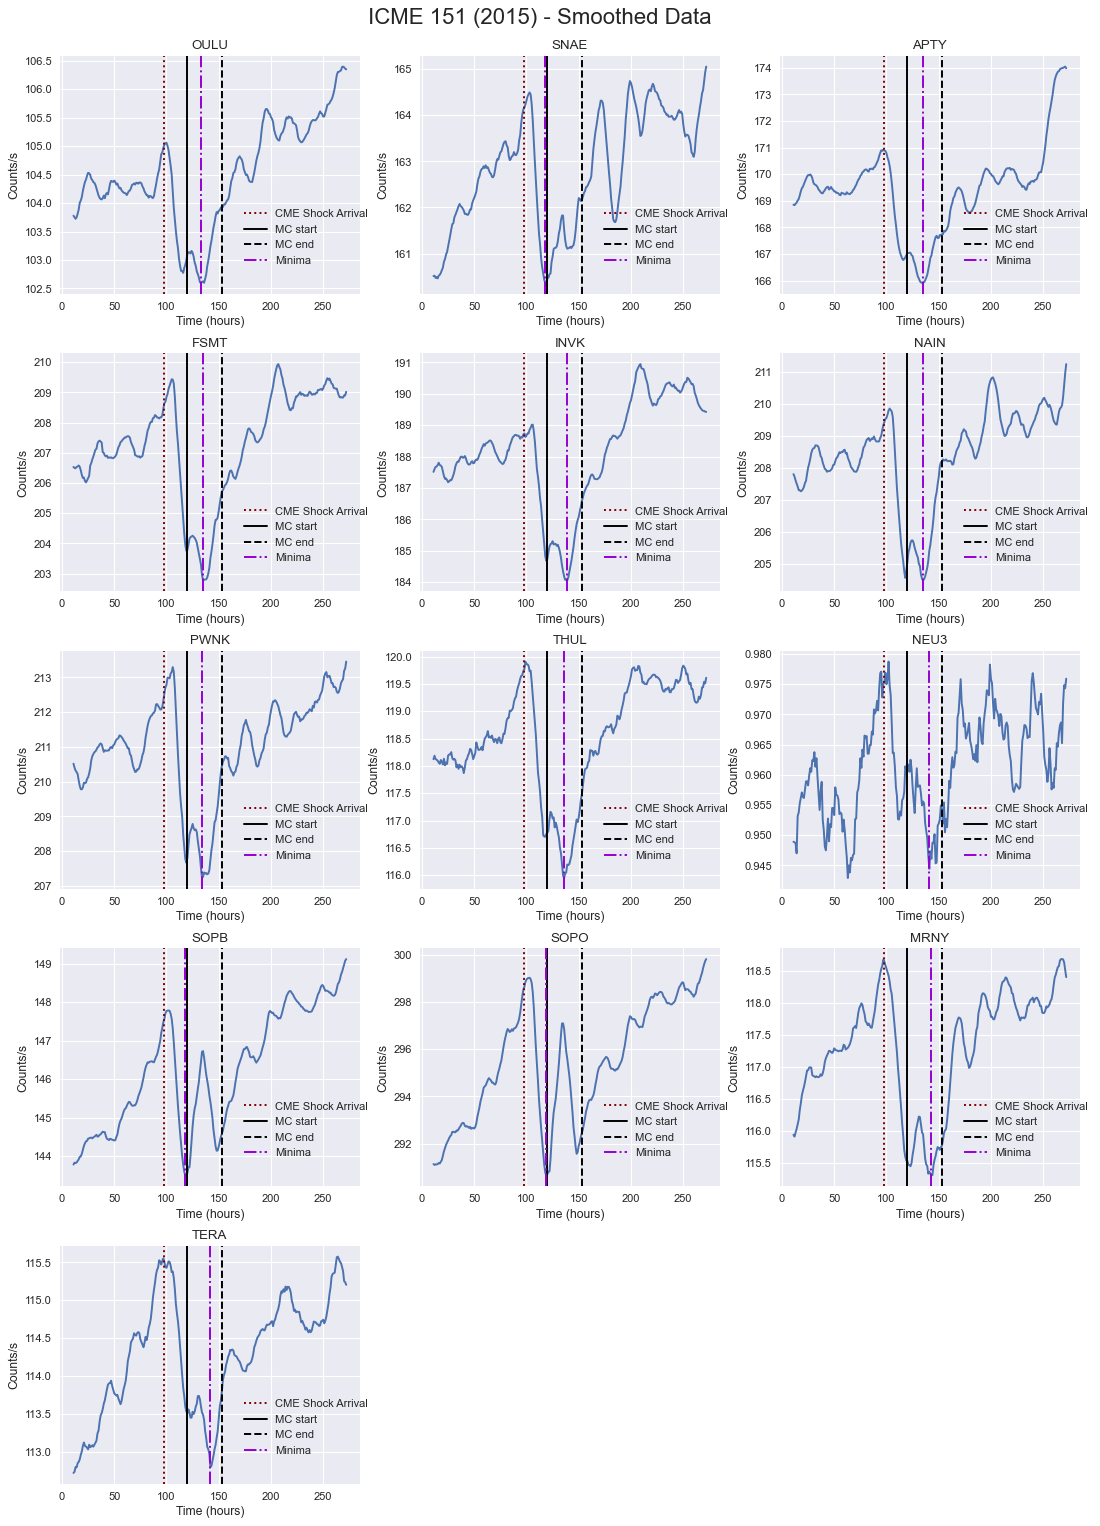

In [19]:
# Plotting all stations in a subplot - ICME 151 smoothed

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)



t, smooraw1, min1 = allstation_analyze("lowrigall_151.txt",1, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw2, min2 = allstation_analyze("lowrigall_151.txt",2, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw3, min3 = allstation_analyze("lowrigall_151.txt",3, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw4, min4 = allstation_analyze("lowrigall_151.txt",4, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw5, min5 = allstation_analyze("lowrigall_151.txt",5, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw6, min6 = allstation_analyze("lowrigall_151.txt",6, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw7, min7 = allstation_analyze("lowrigall_151.txt",7, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw8, min8 = allstation_analyze("lowrigall_151.txt",8, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw9, min9 = allstation_analyze("lowrigall_151.txt",9, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw10, min10 = allstation_analyze("lowrigall_151.txt",10, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw11, min11 = allstation_analyze("lowrigall_151.txt",11, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw12, min12 = allstation_analyze("lowrigall_151.txt",12, 12, "Smoothed", 97.58, 119.67, 153.03,1)
t, smooraw13, min13 = allstation_analyze("lowrigall_151.txt",13, 12, "Smoothed", 97.58, 119.67, 153.03,1)


ax1.plot(t,smooraw1)
# 3 time stamps
ax1.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(119.67, color='black', label='MC start')
ax1.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,smooraw2)
# 3 time stamps
ax2.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(119.67, color='black', label='MC start')
ax2.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")

ax3.plot(t,smooraw3)
# 3 time stamps
ax3.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(119.67, color='black', label='MC start')
ax3.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")

ax4.plot(t,smooraw4)
# 3 time stamps
ax4.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(119.67, color='black', label='MC start')
ax4.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")

ax5.plot(t,smooraw5)
# 3 time stamps
ax5.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax5.axvline(119.67, color='black', label='MC start')
ax5.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")

ax6.plot(t,smooraw6)
# 3 time stamps
ax6.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(119.67, color='black', label='MC start')
ax6.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,smooraw7)
# 3 time stamps
ax7.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(119.67, color='black', label='MC start')
ax7.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")

ax8.plot(t,smooraw8)
# 3 time stamps
ax8.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(119.67, color='black', label='MC start')
ax8.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")

ax9.plot(t,smooraw9)
# 3 time stamps
ax9.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(119.67, color='black', label='MC start')
ax9.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")

ax10.plot(t,smooraw10)
# 3 time stamps
ax10.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(119.67, color='black', label='MC start')
ax10.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,smooraw11)
# 3 time stamps
ax11.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(119.67, color='black', label='MC start')
ax11.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,smooraw12)
# 3 time stamps
ax12.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(119.67, color='black', label='MC start')
ax12.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")

ax13.plot(t,smooraw13)
# 3 time stamps
ax13.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax13.axvline(119.67, color='black', label='MC start')
ax13.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")


ax1.legend(loc=(0.6,0.1))
ax2.legend(loc=(0.6,0.1))
ax3.legend(loc=(0.6,0.1))
ax4.legend(loc=(0.6,0.1))
ax5.legend(loc=(0.6,0.1))
ax6.legend(loc=(0.6,0.1))
ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.1))
ax9.legend(loc=(0.6,0.1))
ax10.legend(loc=(0.6,0.1))
ax11.legend(loc=(0.6,0.1))
ax12.legend(loc=(0.6,0.1))
ax13.legend(loc=(0.6,0.1))
fig.suptitle("ICME 151 (2015) - Smoothed Data", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


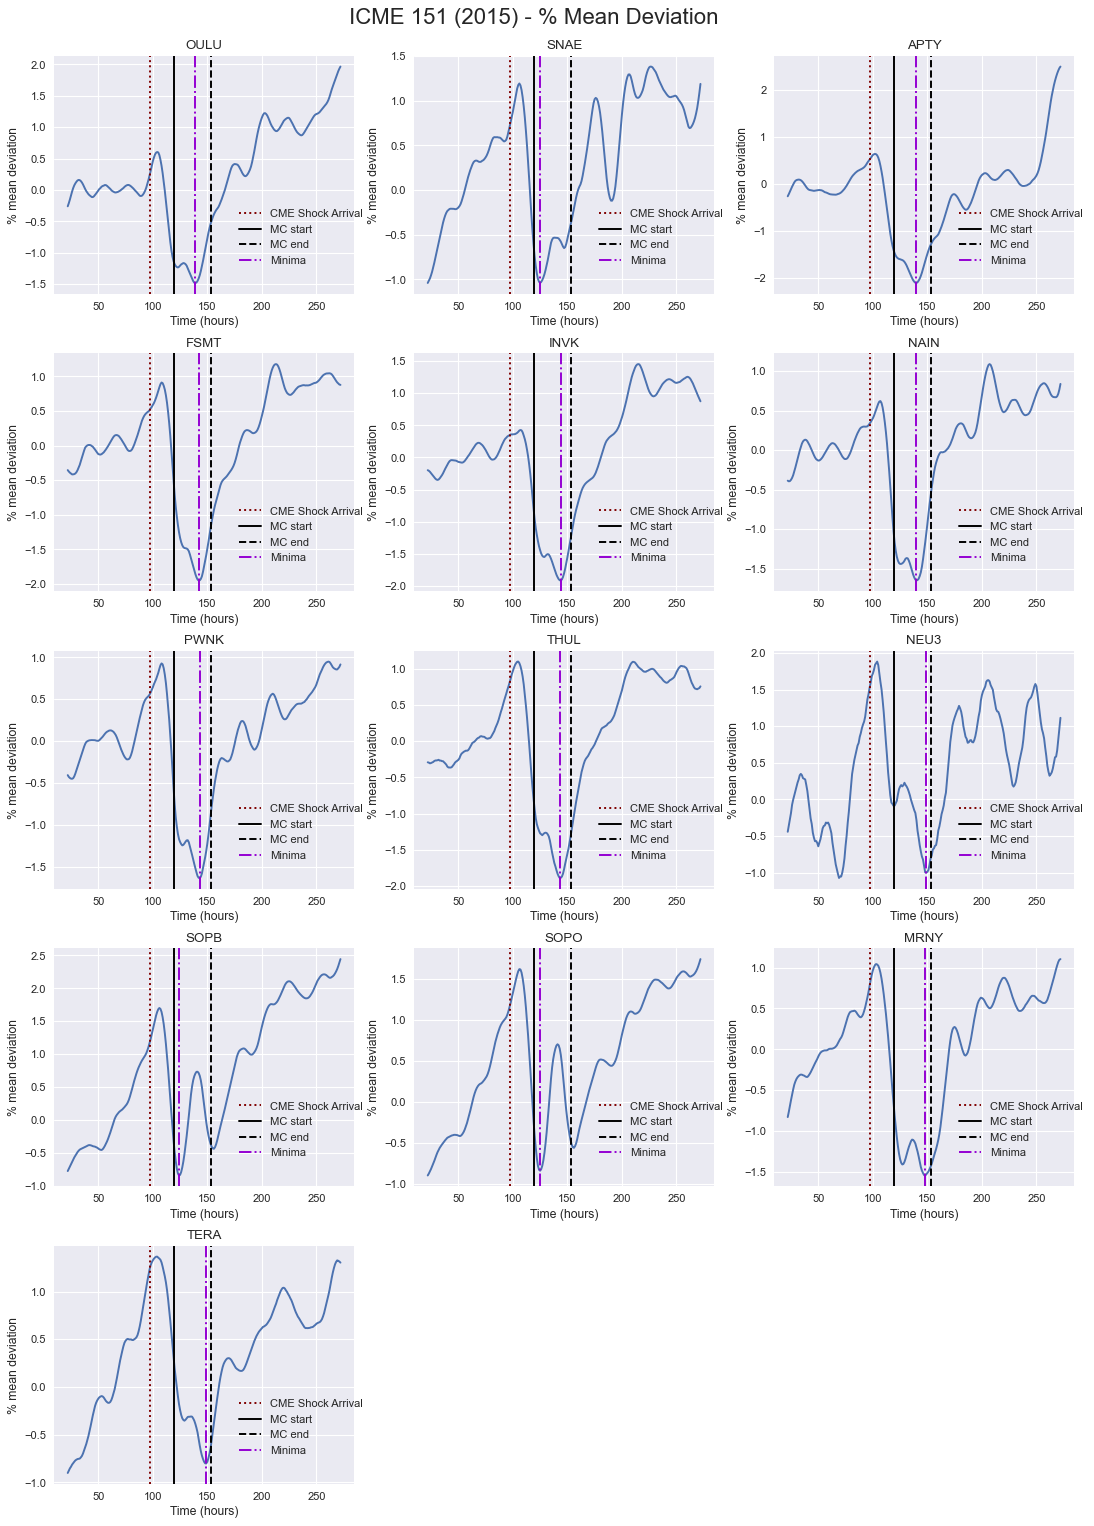

In [20]:
# Plotting all stations in a subplot - ICME 151 %mean dev

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)



t, pdev1, min1 = allstation_analyze("lowrigall_151.txt",1, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev2, min2 = allstation_analyze("lowrigall_151.txt",2, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev3, min3 = allstation_analyze("lowrigall_151.txt",3, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev4, min4 = allstation_analyze("lowrigall_151.txt",4, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev5, min5 = allstation_analyze("lowrigall_151.txt",5, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev6, min6 = allstation_analyze("lowrigall_151.txt",6, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev7, min7 = allstation_analyze("lowrigall_151.txt",7, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev8, min8 = allstation_analyze("lowrigall_151.txt",8, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev9, min9 = allstation_analyze("lowrigall_151.txt",9, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev10, min10 = allstation_analyze("lowrigall_151.txt",10, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev11, min11 = allstation_analyze("lowrigall_151.txt",11, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev12, min12 = allstation_analyze("lowrigall_151.txt",12, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)
t, pdev13, min13 = allstation_analyze("lowrigall_151.txt",13, 12, "Percentdev_smooth", 97.58, 119.67, 153.03,1)


ax1.plot(t,pdev1)
# 3 time stamps
ax1.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(119.67, color='black', label='MC start')
ax1.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")

        
ax2.plot(t,pdev2)
# 3 time stamps
ax2.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(119.67, color='black', label='MC start')
ax2.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")


ax3.plot(t,pdev3)
# 3 time stamps
ax3.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(119.67, color='black', label='MC start')
ax3.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")


ax4.plot(t,pdev4)
# 3 time stamps
ax4.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(119.67, color='black', label='MC start')
ax4.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")


ax5.plot(t,pdev5)
# 3 time stamps
ax5.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax5.axvline(119.67, color='black', label='MC start')
ax5.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")


ax6.plot(t,pdev6)
# 3 time stamps
ax6.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(119.67, color='black', label='MC start')
ax6.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,pdev7)
# 3 time stamps
ax7.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(119.67, color='black', label='MC start')
ax7.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")


ax8.plot(t,pdev8)
# 3 time stamps
ax8.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(119.67, color='black', label='MC start')
ax8.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")


ax9.plot(t,pdev9)
# 3 time stamps
ax9.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(119.67, color='black', label='MC start')
ax9.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")


ax10.plot(t,pdev10)
# 3 time stamps
ax10.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(119.67, color='black', label='MC start')
ax10.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")


ax11.plot(t,pdev11)
# 3 time stamps
ax11.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(119.67, color='black', label='MC start')
ax11.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")


ax12.plot(t,pdev12)
# 3 time stamps
ax12.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(119.67, color='black', label='MC start')
ax12.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")


ax13.plot(t,pdev13)
# 3 time stamps
ax13.axvline(97.58, color='maroon', linestyle=':', label='CME Shock Arrival')
ax13.axvline(119.67, color='black', label='MC start')
ax13.axvline(153.01, color='black', linestyle='--', label="MC end")
# Minima 
ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")


ax1.legend(loc=(0.6,0.1))
ax2.legend(loc=(0.6,0.1))
ax3.legend(loc=(0.6,0.1))
ax4.legend(loc=(0.6,0.1))
ax5.legend(loc=(0.6,0.1))
ax6.legend(loc=(0.6,0.1))
ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.1))
ax9.legend(loc=(0.6,0.1))
ax10.legend(loc=(0.6,0.1))
ax11.legend(loc=(0.6,0.1))
ax12.legend(loc=(0.6,0.1))
ax13.legend(loc=(0.6,0.1))

fig.suptitle("ICME 151 (2015) - % Mean Deviation", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


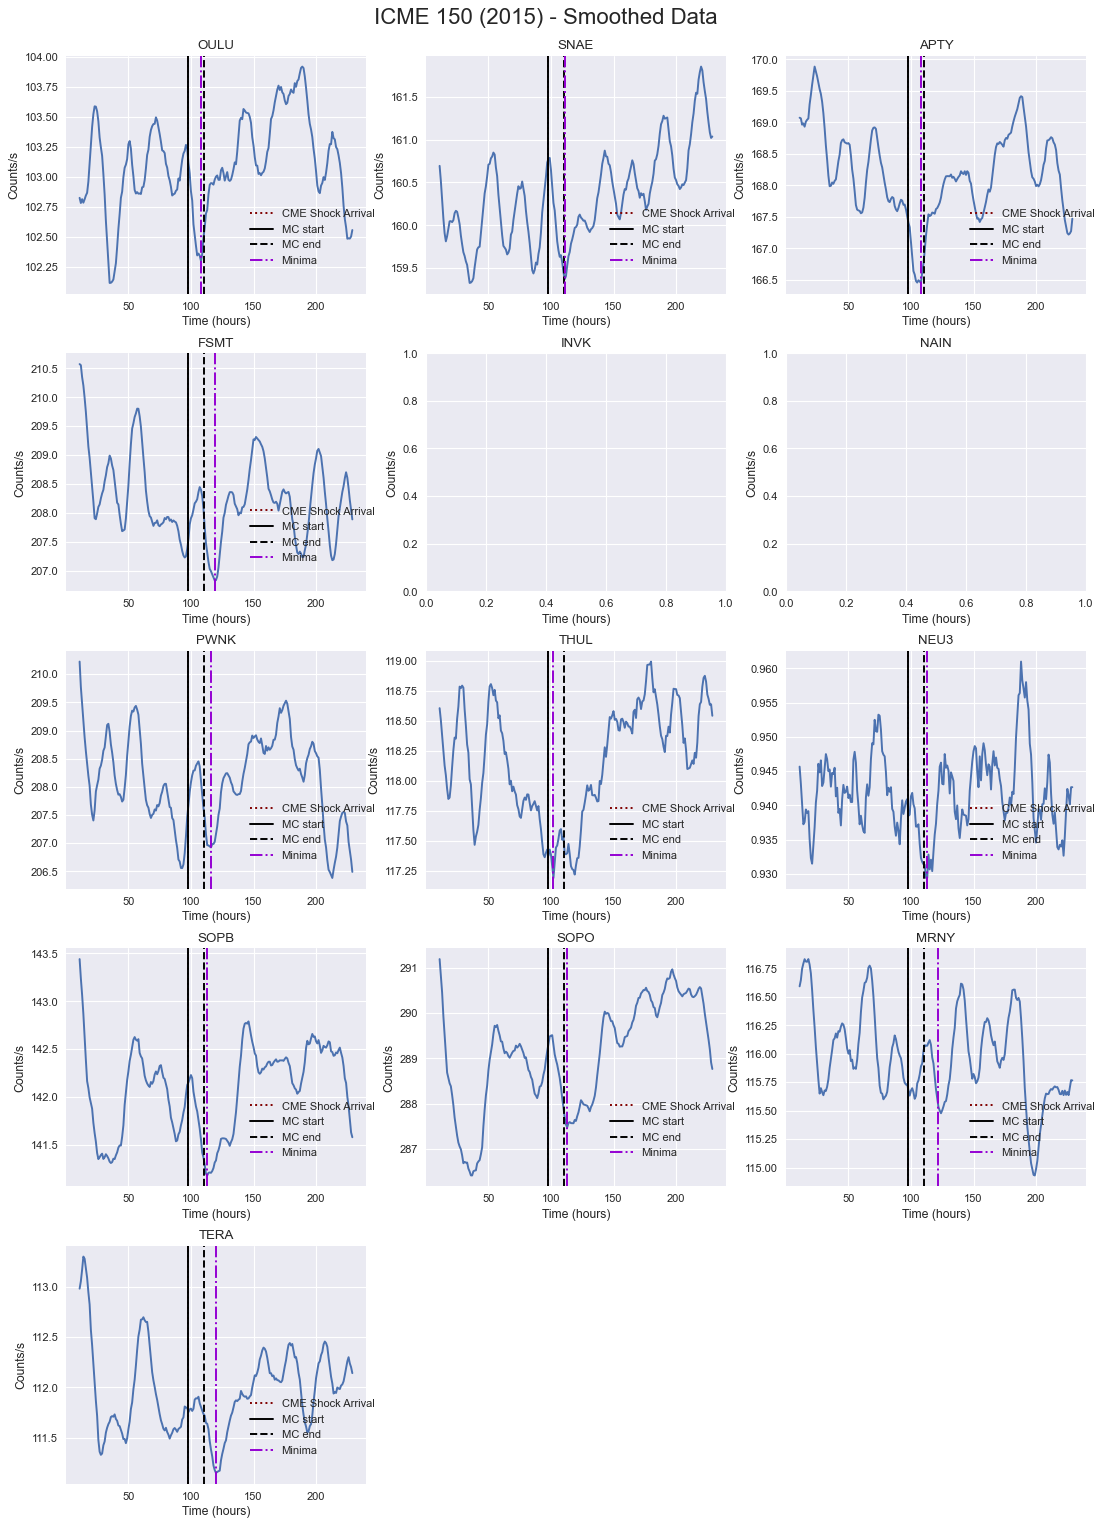

In [26]:
# Plotting all stations in a subplot - ICME 150 smoothed

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)



t, smooraw1, min1 = allstation_analyze("lowrigall_150.txt",1, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw2, min2 = allstation_analyze("lowrigall_150.txt",2, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw3, min3 = allstation_analyze("lowrigall_150.txt",3, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw4, min4 = allstation_analyze("lowrigall_150.txt",4, 12, "Smoothed", 97.58,97.58,110.05,1)
#t, smooraw5, min5 = allstation_analyze("lowrigall_150.txt",5, 12, "Smoothed", 97.58,97.58,110.05,1)
#t, smooraw6, min6 = allstation_analyze("lowrigall_150.txt",6, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw7, min7 = allstation_analyze("lowrigall_150.txt",7, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw8, min8 = allstation_analyze("lowrigall_150.txt",8, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw9, min9 = allstation_analyze("lowrigall_150.txt",9, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw10, min10 = allstation_analyze("lowrigall_150.txt",10, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw11, min11 = allstation_analyze("lowrigall_150.txt",11, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw12, min12 = allstation_analyze("lowrigall_150.txt",12, 12, "Smoothed", 97.58,97.58,110.05,1)
t, smooraw13, min13 = allstation_analyze("lowrigall_150.txt",13, 12, "Smoothed", 97.58,97.58,110.05,1)

shock = 97.58
mcstart = 97.58
mcend = 110.05


ax1.plot(t,smooraw1)
# 3 time stamps
ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(mcstart, color='black', label='MC start')
ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,smooraw2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")

ax3.plot(t,smooraw3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")

ax4.plot(t,smooraw4)
# 3 time stamps
ax4.axvline(shock1, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")

#ax5.plot(t,smooraw5)
# 3 time stamps
#ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax5.axvline(mcstart, color='black', label='MC start')
#ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")

#ax6.plot(t,smooraw6)
# 3 time stamps
#ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax6.axvline(mcstart, color='black', label='MC start')
#ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,smooraw7)
# 3 time stamps
ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(mcstart, color='black', label='MC start')
ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")

ax8.plot(t,smooraw8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")

ax9.plot(t,smooraw9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")

ax10.plot(t,smooraw10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,smooraw11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,smooraw12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")

ax13.plot(t,smooraw13)
# 3 time stamps
ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax13.axvline(mcstart, color='black', label='MC start')
ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")


ax1.legend(loc=(0.6,0.1))
ax2.legend(loc=(0.6,0.1))
ax3.legend(loc=(0.6,0.1))
ax4.legend(loc=(0.6,0.1))
#ax5.legend(loc=(0.6,0.1))
#ax6.legend(loc=(0.6,0.1))
ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.1))
ax9.legend(loc=(0.6,0.1))
ax10.legend(loc=(0.6,0.1))
ax11.legend(loc=(0.6,0.1))
ax12.legend(loc=(0.6,0.1))
ax13.legend(loc=(0.6,0.1))
fig.suptitle("ICME 150 (2015) - Smoothed Data", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


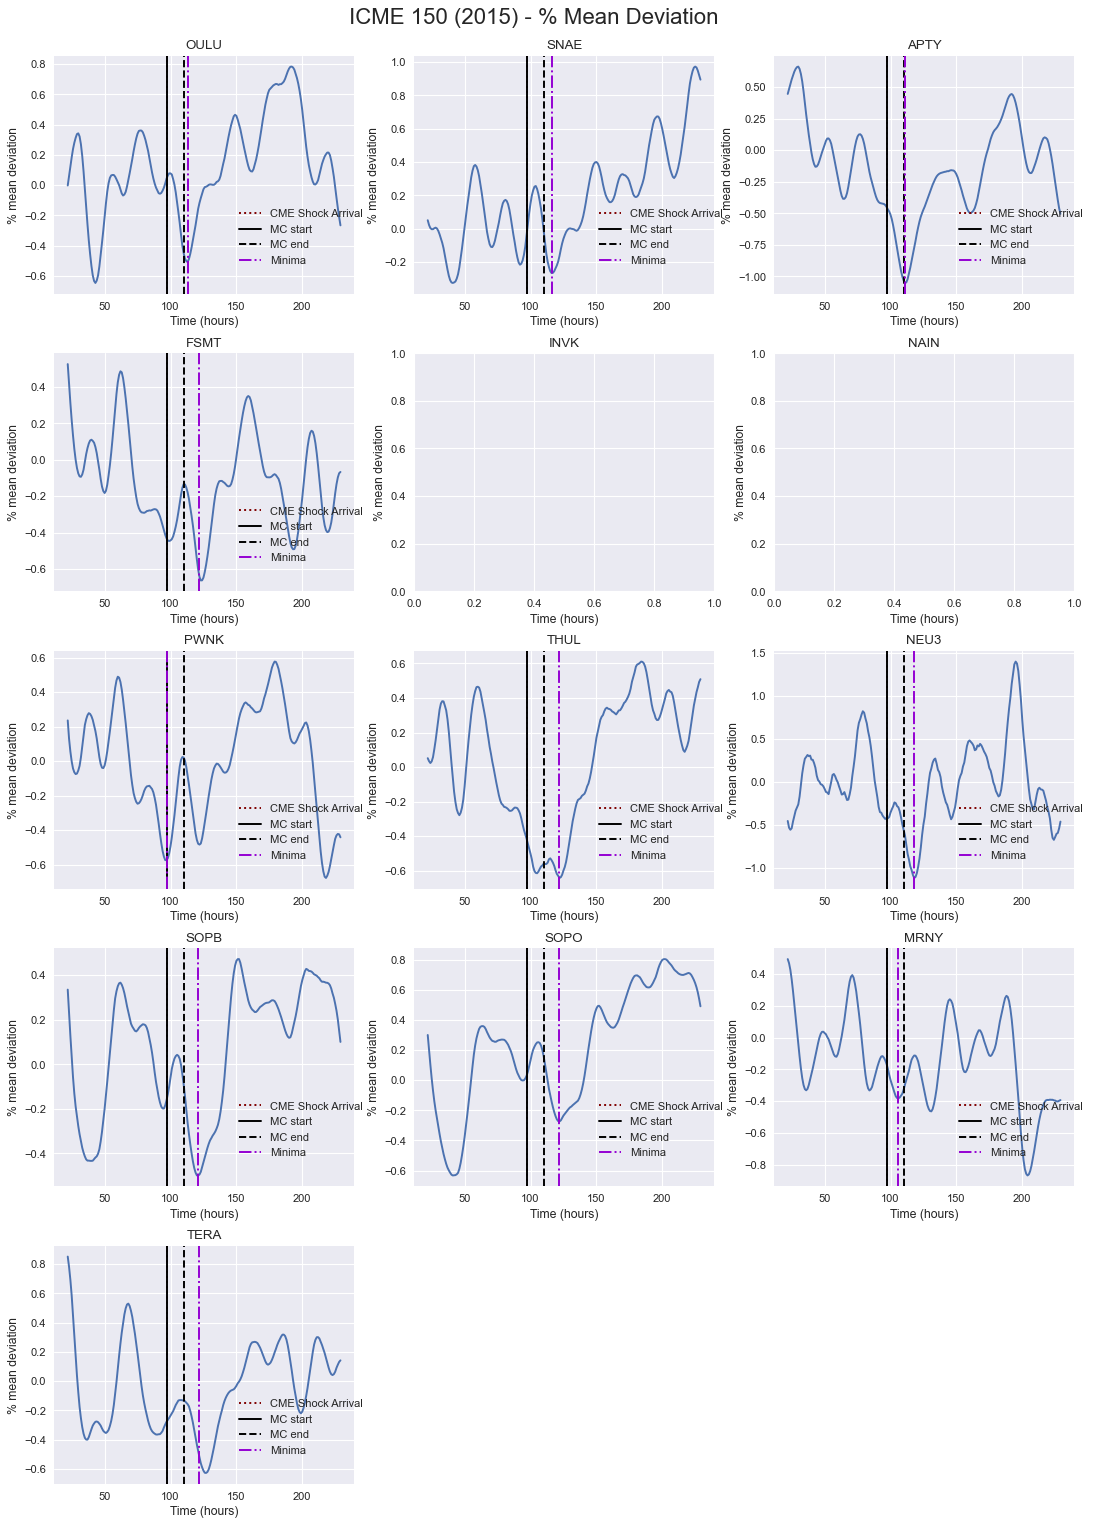

In [18]:
# Plotting all stations in a subplot - ICME 150 %mean dev

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)



t, pdev1, min1 = allstation_analyze("lowrigall_150.txt",1, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev2, min2 = allstation_analyze("lowrigall_150.txt",2, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev3, min3 = allstation_analyze("lowrigall_150.txt",3, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev4, min4 = allstation_analyze("lowrigall_150.txt",4, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
#t, pdev5, min5 = allstation_analyze("lowrigall_150.txt",5, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
#t, pdev6, min6 = allstation_analyze("lowrigall_150.txt",6, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev7, min7 = allstation_analyze("lowrigall_150.txt",7, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev8, min8 = allstation_analyze("lowrigall_150.txt",8, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev9, min9 = allstation_analyze("lowrigall_150.txt",9, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev10, min10 = allstation_analyze("lowrigall_150.txt",10, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev11, min11 = allstation_analyze("lowrigall_150.txt",11, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev12, min12 = allstation_analyze("lowrigall_150.txt",12, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev13, min13 = allstation_analyze("lowrigall_150.txt",13, 12, "Percentdev_smooth", shock, mcstart, mcend,1)


ax1.plot(t,pdev1)
# 3 time stamps
ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(mcstart, color='black', label='MC start')
ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,pdev2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")


ax3.plot(t,pdev3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")


ax4.plot(t,pdev4)
# 3 time stamps
ax4.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")


#ax5.plot(t,pdev5)
# 3 time stamps
#ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax5.axvline(mcstart, color='black', label='MC start')
#ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax6.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")


#ax6.plot(t,pdev6)
# 3 time stamps
#ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax6.axvline(mcstart, color='black', label='MC start')
#ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,pdev7)
# 3 time stamps
ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(mcstart, color='black', label='MC start')
ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")


ax8.plot(t,pdev8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")


ax9.plot(t,pdev9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")


ax10.plot(t,pdev10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,pdev11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,pdev12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")


ax13.plot(t,pdev13)
# 3 time stamps
ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax13.axvline(mcstart, color='black', label='MC start')
ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")

ax1.legend(loc=(0.6,0.1))
ax2.legend(loc=(0.6,0.1))
ax3.legend(loc=(0.6,0.1))
ax4.legend(loc=(0.6,0.1))
#ax5.legend(loc=(0.6,0.1))
#ax6.legend(loc=(0.6,0.1))
ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.1))
ax9.legend(loc=(0.6,0.1))
ax10.legend(loc=(0.6,0.1))
ax11.legend(loc=(0.6,0.1))
ax12.legend(loc=(0.6,0.1))
ax13.legend(loc=(0.6,0.1))

fig.suptitle("ICME 150 (2015) - % Mean Deviation", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


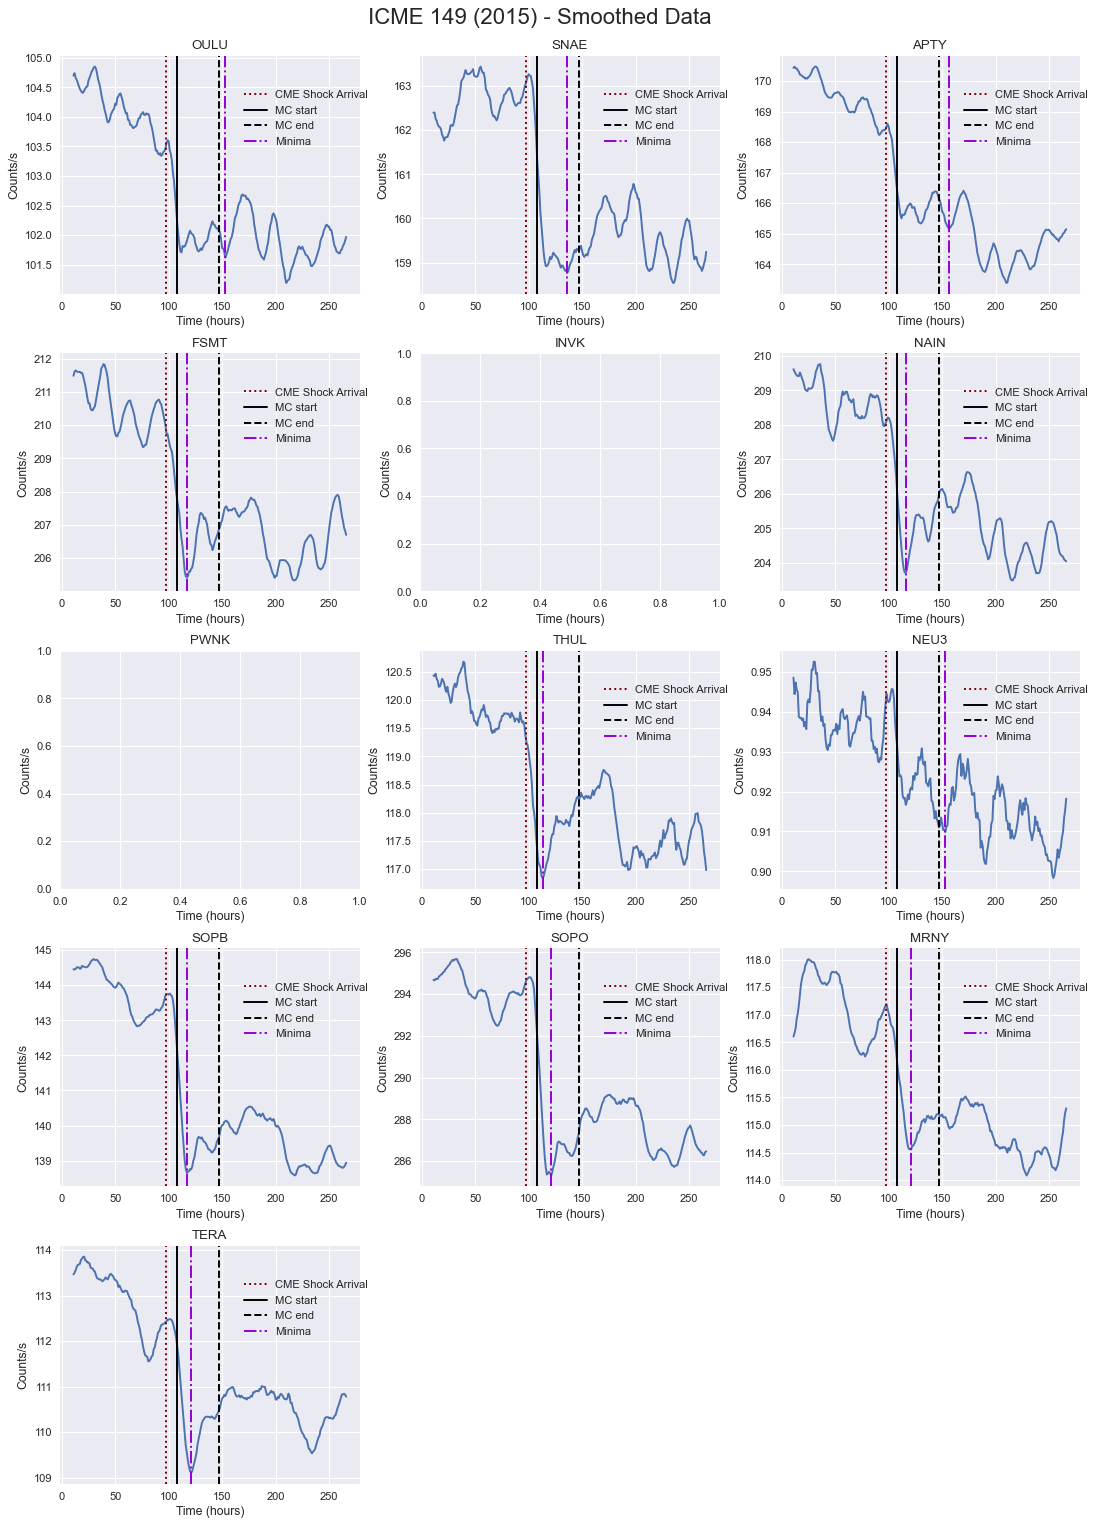

In [19]:
# Plotting all stations in a subplot - ICME 149 smoothed

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)



t, smooraw1, min1 = allstation_analyze("lowrigall_149.txt",1, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw2, min2 = allstation_analyze("lowrigall_149.txt",2, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw3, min3 = allstation_analyze("lowrigall_149.txt",3, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw4, min4 = allstation_analyze("lowrigall_149.txt",4, 12, "Smoothed", 97.08, 107.52, 146.87,1)
#t, smooraw5, min5 = allstation_analyze("lowrigall_149.txt",5, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw6, min6 = allstation_analyze("lowrigall_149.txt",6, 12, "Smoothed", 97.08, 107.52, 146.87,1)
#t, smooraw7, min7 = allstation_analyze("lowrigall_149.txt",7, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw8, min8 = allstation_analyze("lowrigall_149.txt",8, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw9, min9 = allstation_analyze("lowrigall_149.txt",9, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw10, min10 = allstation_analyze("lowrigall_149.txt",10, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw11, min11 = allstation_analyze("lowrigall_149.txt",11, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw12, min12 = allstation_analyze("lowrigall_149.txt",12, 12, "Smoothed", 97.08, 107.52, 146.87,1)
t, smooraw13, min13 = allstation_analyze("lowrigall_149.txt",13, 12, "Smoothed", 97.08, 107.52, 146.87,1)

shock = 97.08
mcstart = 107.52
mcend = 146.87


ax1.plot(t,smooraw1)
# 3 time stamps
ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(mcstart, color='black', label='MC start')
ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,smooraw2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")

ax3.plot(t,smooraw3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")

ax4.plot(t,smooraw4)
# 3 time stamps
ax4.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")

#ax5.plot(t,smooraw5)
# 3 time stamps
#ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax5.axvline(mcstart, color='black', label='MC start')
#ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")

ax6.plot(t,smooraw6)
# 3 time stamps
ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(mcstart, color='black', label='MC start')
ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

#ax7.plot(t,smooraw7)
# 3 time stamps
#ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax7.axvline(mcstart, color='black', label='MC start')
#ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")

ax8.plot(t,smooraw8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")

ax9.plot(t,smooraw9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")

ax10.plot(t,smooraw10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,smooraw11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,smooraw12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")

ax13.plot(t,smooraw13)
# 3 time stamps
ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax13.axvline(mcstart, color='black', label='MC start')
ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")


ax1.legend(loc=(0.6,0.6))
ax2.legend(loc=(0.6,0.6))
ax3.legend(loc=(0.6,0.6))
ax4.legend(loc=(0.6,0.6))
#ax5.legend(loc=(0.6,0.1))
ax6.legend(loc=(0.6,0.6))
#ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.6))
ax9.legend(loc=(0.6,0.6))
ax10.legend(loc=(0.6,0.6))
ax11.legend(loc=(0.6,0.6))
ax12.legend(loc=(0.6,0.6))
ax13.legend(loc=(0.6,0.6))
fig.suptitle("ICME 149 (2015) - Smoothed Data", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


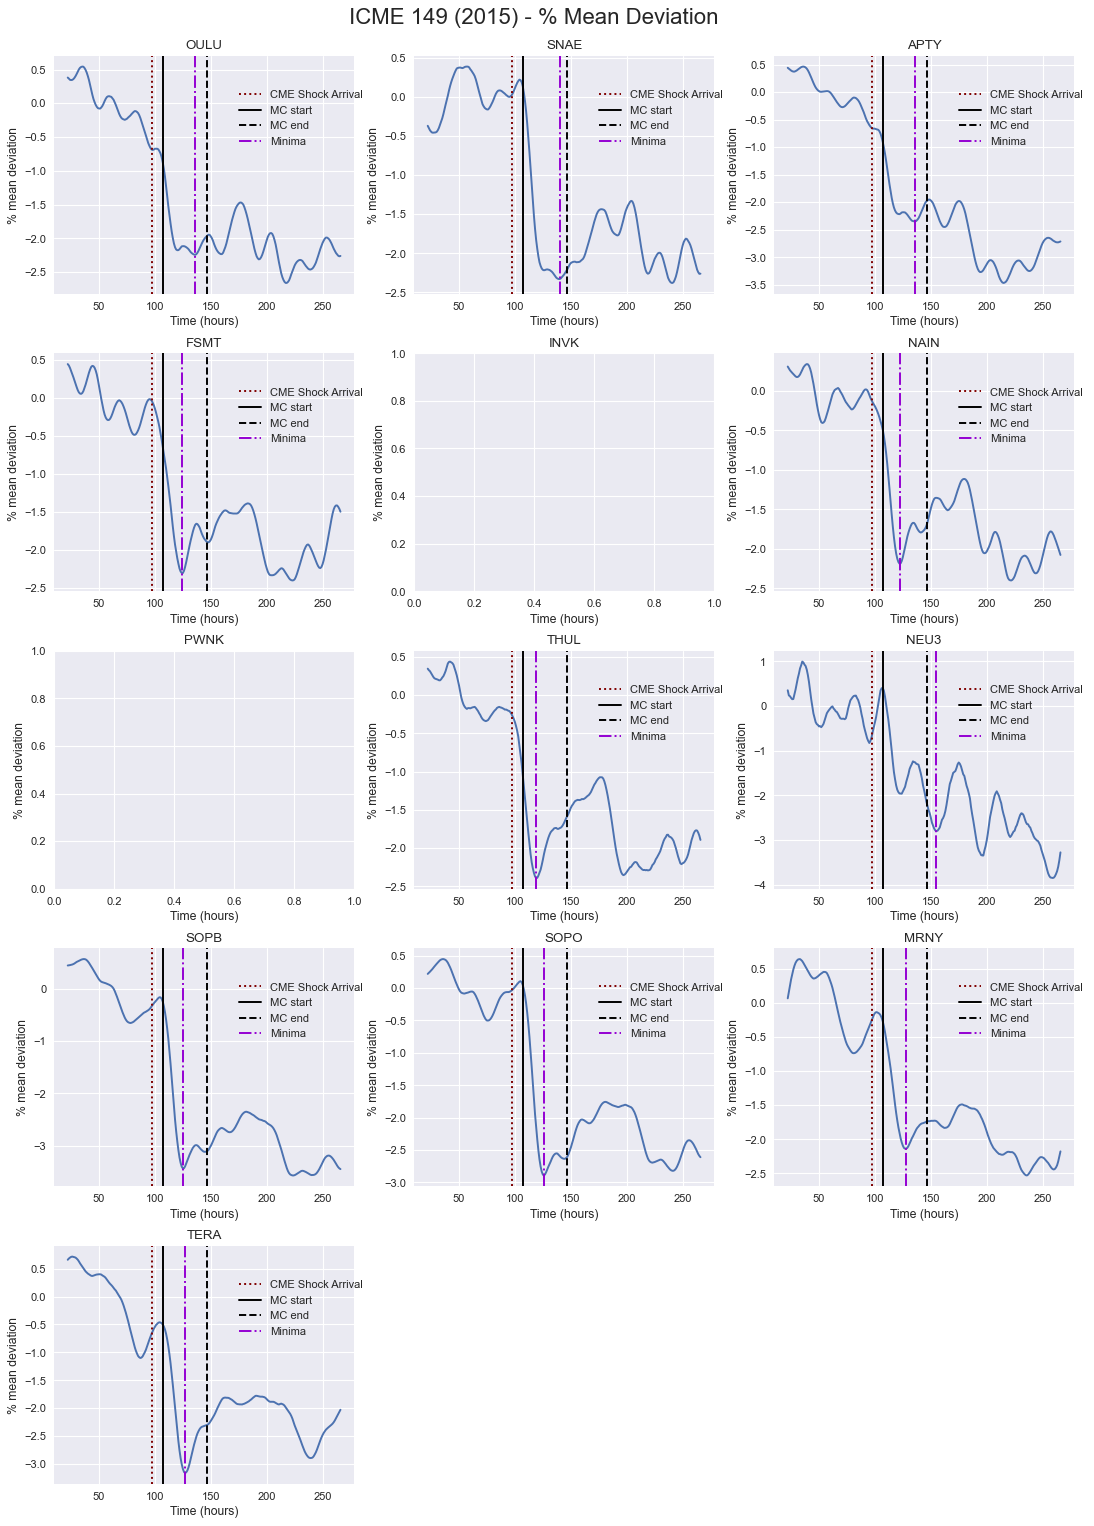

In [20]:
# Plotting all stations in a subplot - ICME 149 %mean dev

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)

shock = 97.08  
mcstart = 107.52
mcend = 146.87


t, pdev1, min1 = allstation_analyze("lowrigall_149.txt",1, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev2, min2 = allstation_analyze("lowrigall_149.txt",2, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev3, min3 = allstation_analyze("lowrigall_149.txt",3, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev4, min4 = allstation_analyze("lowrigall_149.txt",4, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
#t, pdev5, min5 = allstation_analyze("lowrigall_149.txt",5, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev6, min6 = allstation_analyze("lowrigall_149.txt",6, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
#t, pdev7, min7 = allstation_analyze("lowrigall_149.txt",7, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev8, min8 = allstation_analyze("lowrigall_149.txt",8, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev9, min9 = allstation_analyze("lowrigall_149.txt",9, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev10, min10 = allstation_analyze("lowrigall_149.txt",10, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev11, min11 = allstation_analyze("lowrigall_149.txt",11, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev12, min12 = allstation_analyze("lowrigall_149.txt",12, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev13, min13 = allstation_analyze("lowrigall_149.txt",13, 12, "Percentdev_smooth", shock, mcstart, mcend,1)


ax1.plot(t,pdev1)
# 3 time stamps
ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(mcstart, color='black', label='MC start')
ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,pdev2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")


ax3.plot(t,pdev3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")


ax4.plot(t,pdev4)
# 3 time stamps
ax4.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")


#ax5.plot(t,pdev5)
# 3 time stamps
#ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax5.axvline(mcstart, color='black', label='MC start')
#ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax6.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")


ax6.plot(t,pdev6)
# 3 time stamps
ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(mcstart, color='black', label='MC start')
ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

#ax7.plot(t,pdev7)
# 3 time stamps
#ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax7.axvline(mcstart, color='black', label='MC start')
#ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")


ax8.plot(t,pdev8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")


ax9.plot(t,pdev9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")


ax10.plot(t,pdev10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,pdev11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,pdev12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")


ax13.plot(t,pdev13)
# 3 time stamps
ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax13.axvline(mcstart, color='black', label='MC start')
ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")

ax1.legend(loc=(0.6,0.6))
ax2.legend(loc=(0.6,0.6))
ax3.legend(loc=(0.6,0.6))
ax4.legend(loc=(0.6,0.6))
#ax5.legend(loc=(0.6,0.6))
ax6.legend(loc=(0.6,0.6))
#ax7.legend(loc=(0.6,0.6))
ax8.legend(loc=(0.6,0.6))
ax9.legend(loc=(0.6,0.6))
ax10.legend(loc=(0.6,0.6))
ax11.legend(loc=(0.6,0.6))
ax12.legend(loc=(0.6,0.6))
ax13.legend(loc=(0.6,0.6))

fig.suptitle("ICME 149 (2015) - % Mean Deviation", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


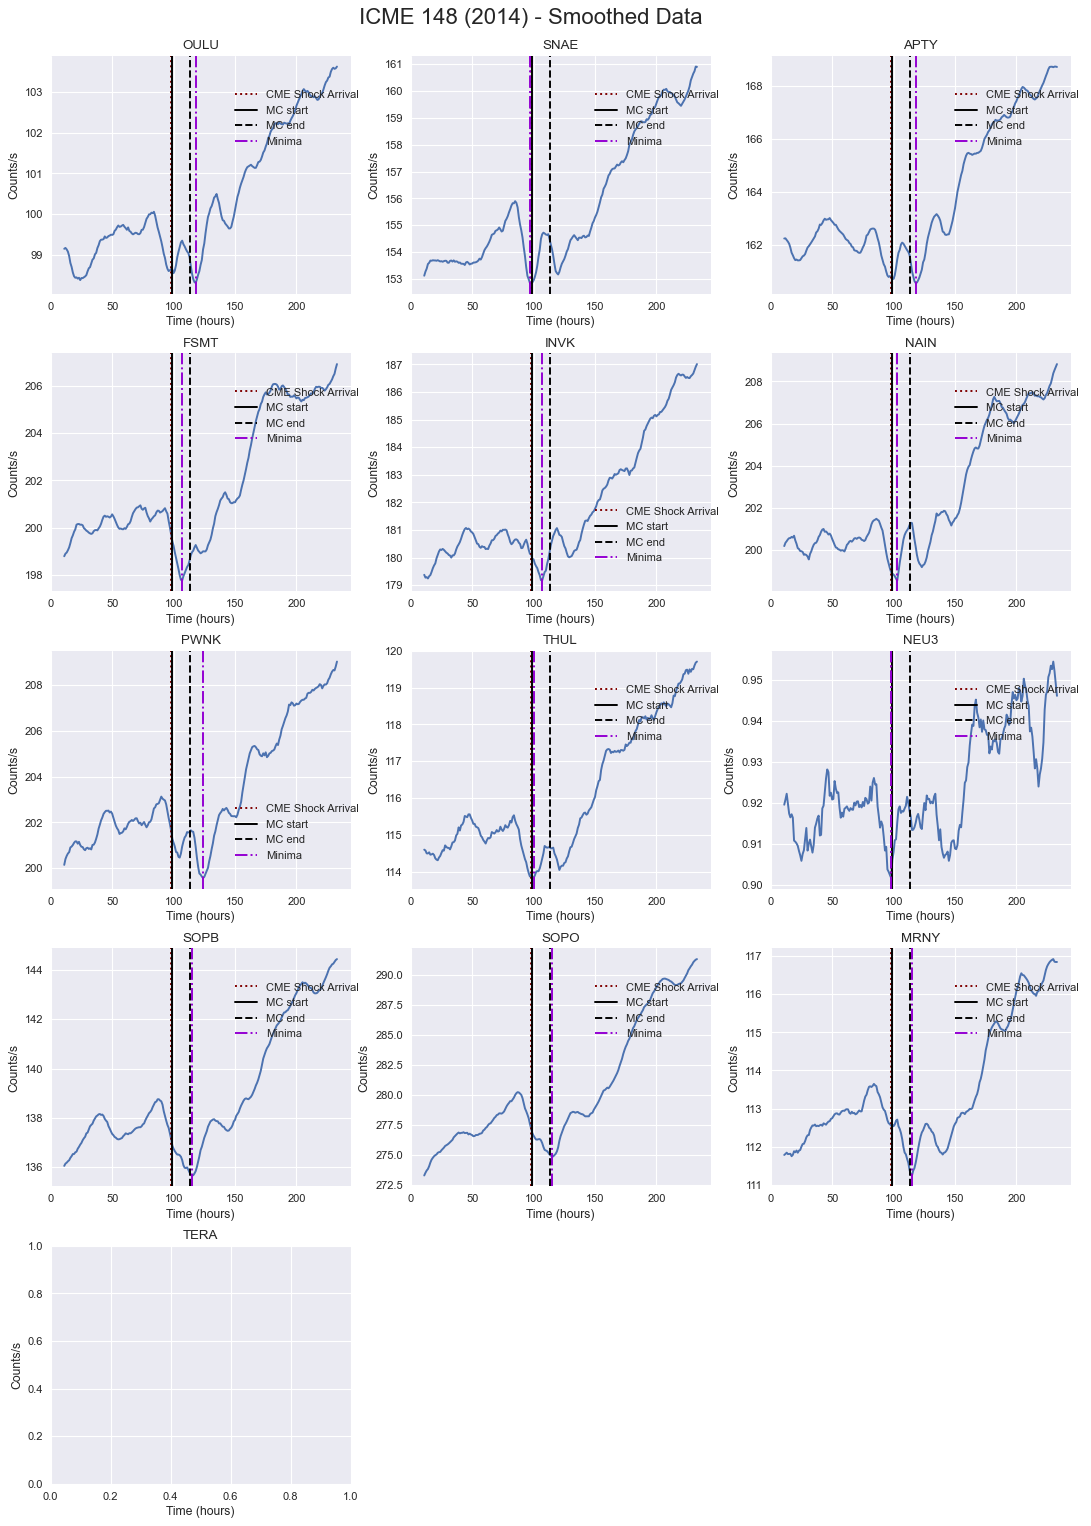

In [21]:
# Plotting all stations in a subplot - ICME 148 smoothed

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)


shock = 97.63
mcstart = 98.47
mcend = 113.12

t, smooraw1, min1 = allstation_analyze("lowrigall_148.txt",1, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw2, min2 = allstation_analyze("lowrigall_148.txt",2, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw3, min3 = allstation_analyze("lowrigall_148.txt",3, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw4, min4 = allstation_analyze("lowrigall_148.txt",4, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw5, min5 = allstation_analyze("lowrigall_148.txt",5, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw6, min6 = allstation_analyze("lowrigall_148.txt",6, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw7, min7 = allstation_analyze("lowrigall_148.txt",7, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw8, min8 = allstation_analyze("lowrigall_148.txt",8, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw9, min9 = allstation_analyze("lowrigall_148.txt",9, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw10, min10 = allstation_analyze("lowrigall_148.txt",10, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw11, min11 = allstation_analyze("lowrigall_148.txt",11, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw12, min12 = allstation_analyze("lowrigall_148.txt",12, 12, "Smoothed", shock, mcstart, mcend,1)
#t, smooraw13, min13 = allstation_analyze("lowrigall_148.txt",13, 12, "Smoothed", 97.08, 107.52, 146.87,1)




ax1.plot(t,smooraw1)
# 3 time stamps
ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(mcstart, color='black', label='MC start')
ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,smooraw2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")

ax3.plot(t,smooraw3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")

ax4.plot(t,smooraw4)
# 3 time stamps
ax4.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")

ax5.plot(t,smooraw5)
# 3 time stamps
ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax5.axvline(mcstart, color='black', label='MC start')
ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")

ax6.plot(t,smooraw6)
# 3 time stamps
ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(mcstart, color='black', label='MC start')
ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,smooraw7)
# 3 time stamps
ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(mcstart, color='black', label='MC start')
ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")

ax8.plot(t,smooraw8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")

ax9.plot(t,smooraw9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")

ax10.plot(t,smooraw10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,smooraw11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,smooraw12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")

#ax13.plot(t,smooraw13)
# 3 time stamps
#ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax13.axvline(mcstart, color='black', label='MC start')
#ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")


ax1.legend(loc=(0.6,0.6))
ax2.legend(loc=(0.6,0.6))
ax3.legend(loc=(0.6,0.6))
ax4.legend(loc=(0.6,0.6))
ax5.legend(loc=(0.6,0.1))
ax6.legend(loc=(0.6,0.6))
ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.6))
ax9.legend(loc=(0.6,0.6))
ax10.legend(loc=(0.6,0.6))
ax11.legend(loc=(0.6,0.6))
ax12.legend(loc=(0.6,0.6))
#ax13.legend(loc=(0.6,0.6))
fig.suptitle("ICME 148 (2014) - Smoothed Data", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good


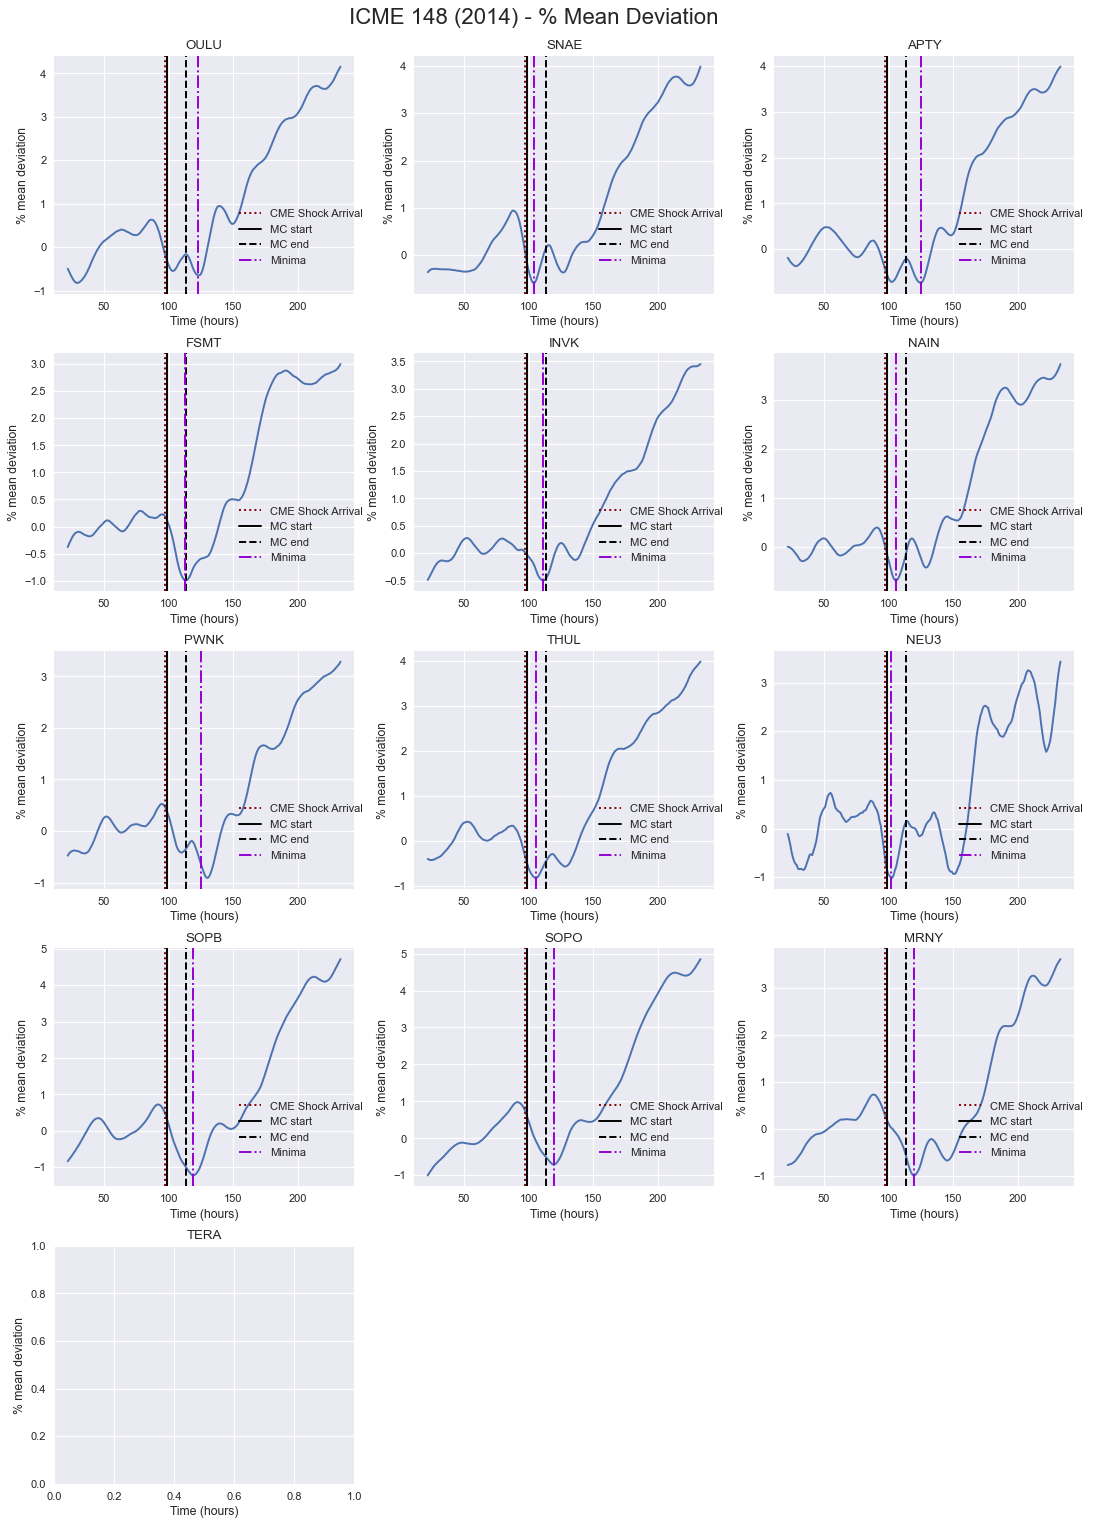

In [22]:
# Plotting all stations in a subplot - ICME 148 %mean dev

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="% mean deviation") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="% mean deviation") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)

shock = 97.63
mcstart = 98.47
mcend = 113.12

t, pdev1, min1 = allstation_analyze("lowrigall_148.txt",1, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev2, min2 = allstation_analyze("lowrigall_148.txt",2, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev3, min3 = allstation_analyze("lowrigall_148.txt",3, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev4, min4 = allstation_analyze("lowrigall_148.txt",4, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev5, min5 = allstation_analyze("lowrigall_148.txt",5, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev6, min6 = allstation_analyze("lowrigall_148.txt",6, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev7, min7 = allstation_analyze("lowrigall_148.txt",7, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev8, min8 = allstation_analyze("lowrigall_148.txt",8, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev9, min9 = allstation_analyze("lowrigall_148.txt",9, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev10, min10 = allstation_analyze("lowrigall_148.txt",10, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev11, min11 = allstation_analyze("lowrigall_148.txt",11, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev12, min12 = allstation_analyze("lowrigall_148.txt",12, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
#t, pdev13, min13 = allstation_analyze("lowrigall_148.txt",13, 12, "Percentdev_smooth", shock, mcstart, mcend,1)


ax1.plot(t,pdev1)
# 3 time stamps
ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax1.axvline(mcstart, color='black', label='MC start')
ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,pdev2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")


ax3.plot(t,pdev3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")


ax4.plot(t,pdev4)
# 3 time stamps
ax4.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")


ax5.plot(t,pdev5)
# 3 time stamps
ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax5.axvline(mcstart, color='black', label='MC start')
ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")


ax6.plot(t,pdev6)
# 3 time stamps
ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(mcstart, color='black', label='MC start')
ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,pdev7)
# 3 time stamps
ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(mcstart, color='black', label='MC start')
ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")


ax8.plot(t,pdev8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")


ax9.plot(t,pdev9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")


ax10.plot(t,pdev10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,pdev11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,pdev12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")


#ax13.plot(t,pdev13)
# 3 time stamps
#ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax13.axvline(mcstart, color='black', label='MC start')
#ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima #
#ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")

ax1.legend(loc=(0.6,0.1))
ax2.legend(loc=(0.6,0.1))
ax3.legend(loc=(0.6,0.1))
ax4.legend(loc=(0.6,0.1))
ax5.legend(loc=(0.6,0.1))
ax6.legend(loc=(0.6,0.1))
ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.1))
ax9.legend(loc=(0.6,0.1))
ax10.legend(loc=(0.6,0.1))
ax11.legend(loc=(0.6,0.1))
ax12.legend(loc=(0.6,0.1))
#ax13.legend(loc=(0.6,0.6))

fig.suptitle("ICME 148 (2014) - % Mean Deviation", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Alert!! Forbush Increases lol!!!
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Alert!! Forbush Increases lol!!!
Alert!! Forbush Increases lol!!!
Seems good
Seems good


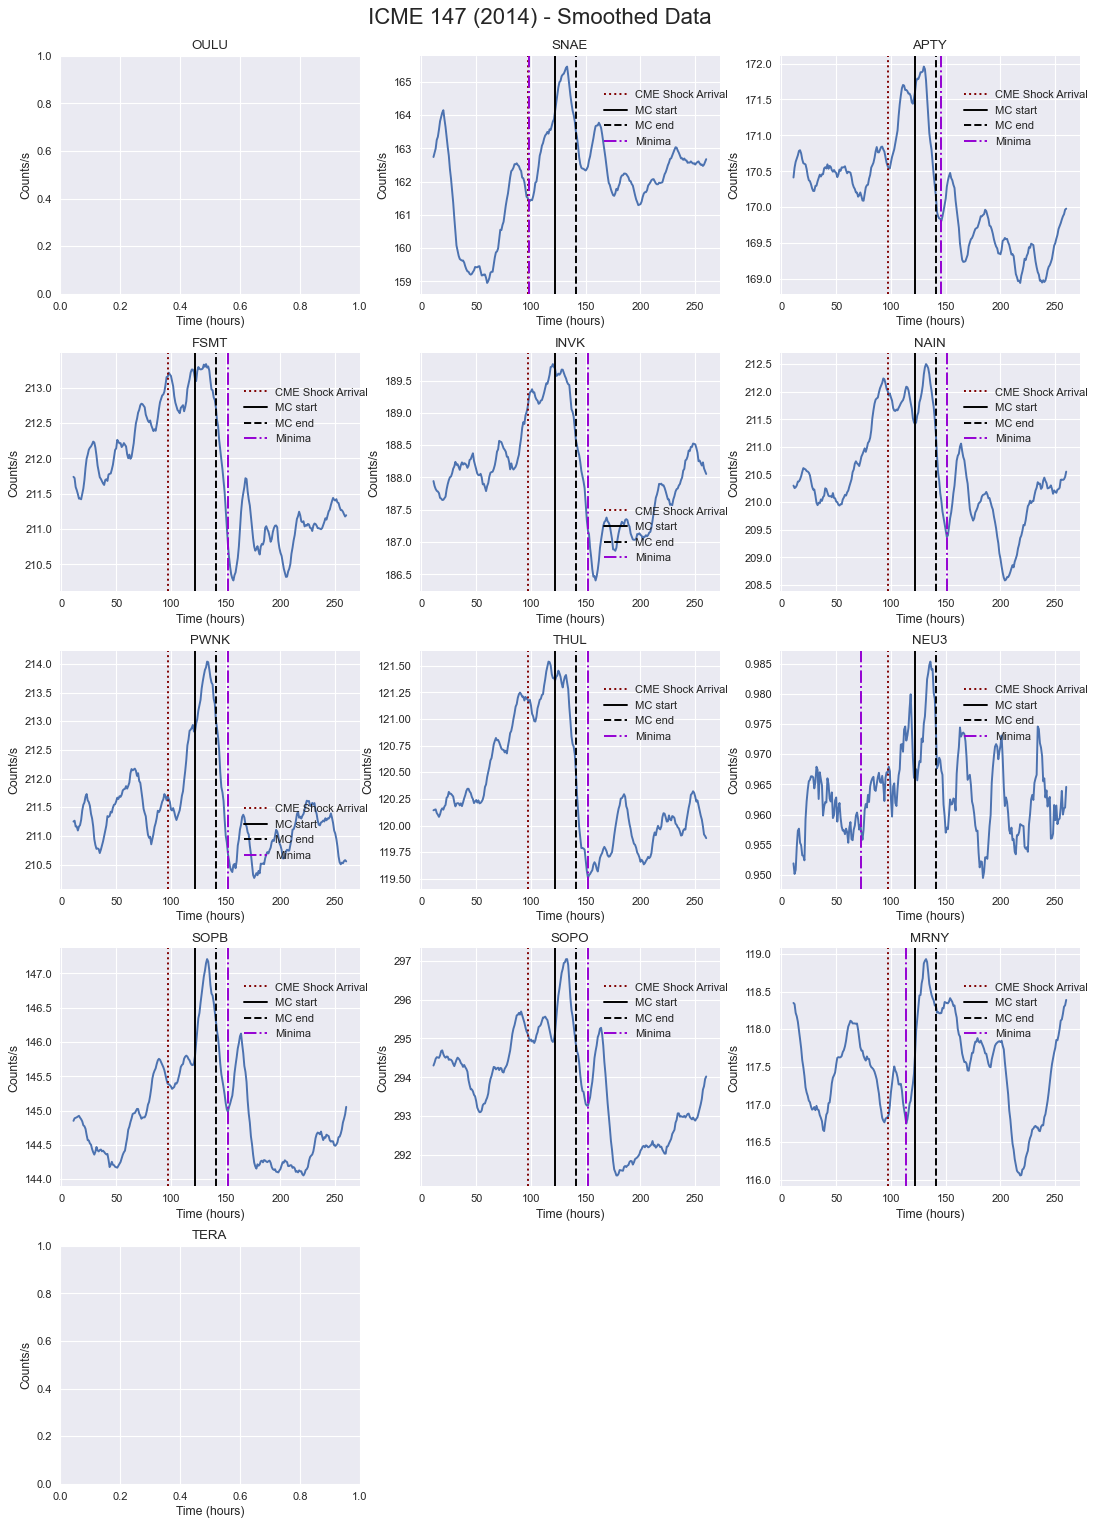

In [23]:
# Plotting all stations in a subplot - ICME 147 smoothed

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="Counts/s") #set title and axis labels here

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="Counts/s") # the three numbers are important!


fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)


shock = 97.67
mcstart = 122.12
mcend = 140.82

#t, smooraw1, min1 = allstation_analyze("lowrigall_147.txt",1, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw2, min2 = allstation_analyze("lowrigall_147.txt",2, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw3, min3 = allstation_analyze("lowrigall_147.txt",3, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw4, min4 = allstation_analyze("lowrigall_147.txt",4, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw5, min5 = allstation_analyze("lowrigall_147.txt",5, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw6, min6 = allstation_analyze("lowrigall_147.txt",6, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw7, min7 = allstation_analyze("lowrigall_147.txt",7, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw8, min8 = allstation_analyze("lowrigall_147.txt",8, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw9, min9 = allstation_analyze("lowrigall_147.txt",9, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw10, min10 = allstation_analyze("lowrigall_147.txt",10, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw11, min11 = allstation_analyze("lowrigall_147.txt",11, 12, "Smoothed", shock, mcstart, mcend,1)
t, smooraw12, min12 = allstation_analyze("lowrigall_147.txt",12, 12, "Smoothed", shock, mcstart, mcend,1)
#t, smooraw13, min13 = allstation_analyze("lowrigall_147.txt",13, 12, "Smoothed", 97.08, 107.52, 146.87,1)




#ax1.plot(t,smooraw1)
# 3 time stamps
#ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax1.axvline(mcstart, color='black', label='MC start')
#ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,smooraw2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")

ax3.plot(t,smooraw3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")

ax4.plot(t,smooraw4)
# 3 time stamps
ax4.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")

ax5.plot(t,smooraw5)
# 3 time stamps
ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax5.axvline(mcstart, color='black', label='MC start')
ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")

ax6.plot(t,smooraw6)
# 3 time stamps
ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(mcstart, color='black', label='MC start')
ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,smooraw7)
# 3 time stamps
ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(mcstart, color='black', label='MC start')
ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")

ax8.plot(t,smooraw8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")

ax9.plot(t,smooraw9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")

ax10.plot(t,smooraw10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,smooraw11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,smooraw12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")

#ax13.plot(t,smooraw13)
# 3 time stamps
#ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax13.axvline(mcstart, color='black', label='MC start')
#ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")


#ax1.legend(loc=(0.6,0.6))
ax2.legend(loc=(0.6,0.6))
ax3.legend(loc=(0.6,0.6))
ax4.legend(loc=(0.6,0.6))
ax5.legend(loc=(0.6,0.1))
ax6.legend(loc=(0.6,0.6))
ax7.legend(loc=(0.6,0.1))
ax8.legend(loc=(0.6,0.6))
ax9.legend(loc=(0.6,0.6))
ax10.legend(loc=(0.6,0.6))
ax11.legend(loc=(0.6,0.6))
ax12.legend(loc=(0.6,0.6))
#ax13.legend(loc=(0.6,0.6))
fig.suptitle("ICME 147 (2014) - Smoothed Data", fontsize=20, y=1.24) #optional overall figure title
plt.show()

Alert!! Forbush Increases lol!!!
Seems good
Seems good
Seems good
Seems good
Seems good
Seems good
Alert!! Forbush Increases lol!!!
Alert!! Forbush Increases lol!!!
Seems good
Seems good


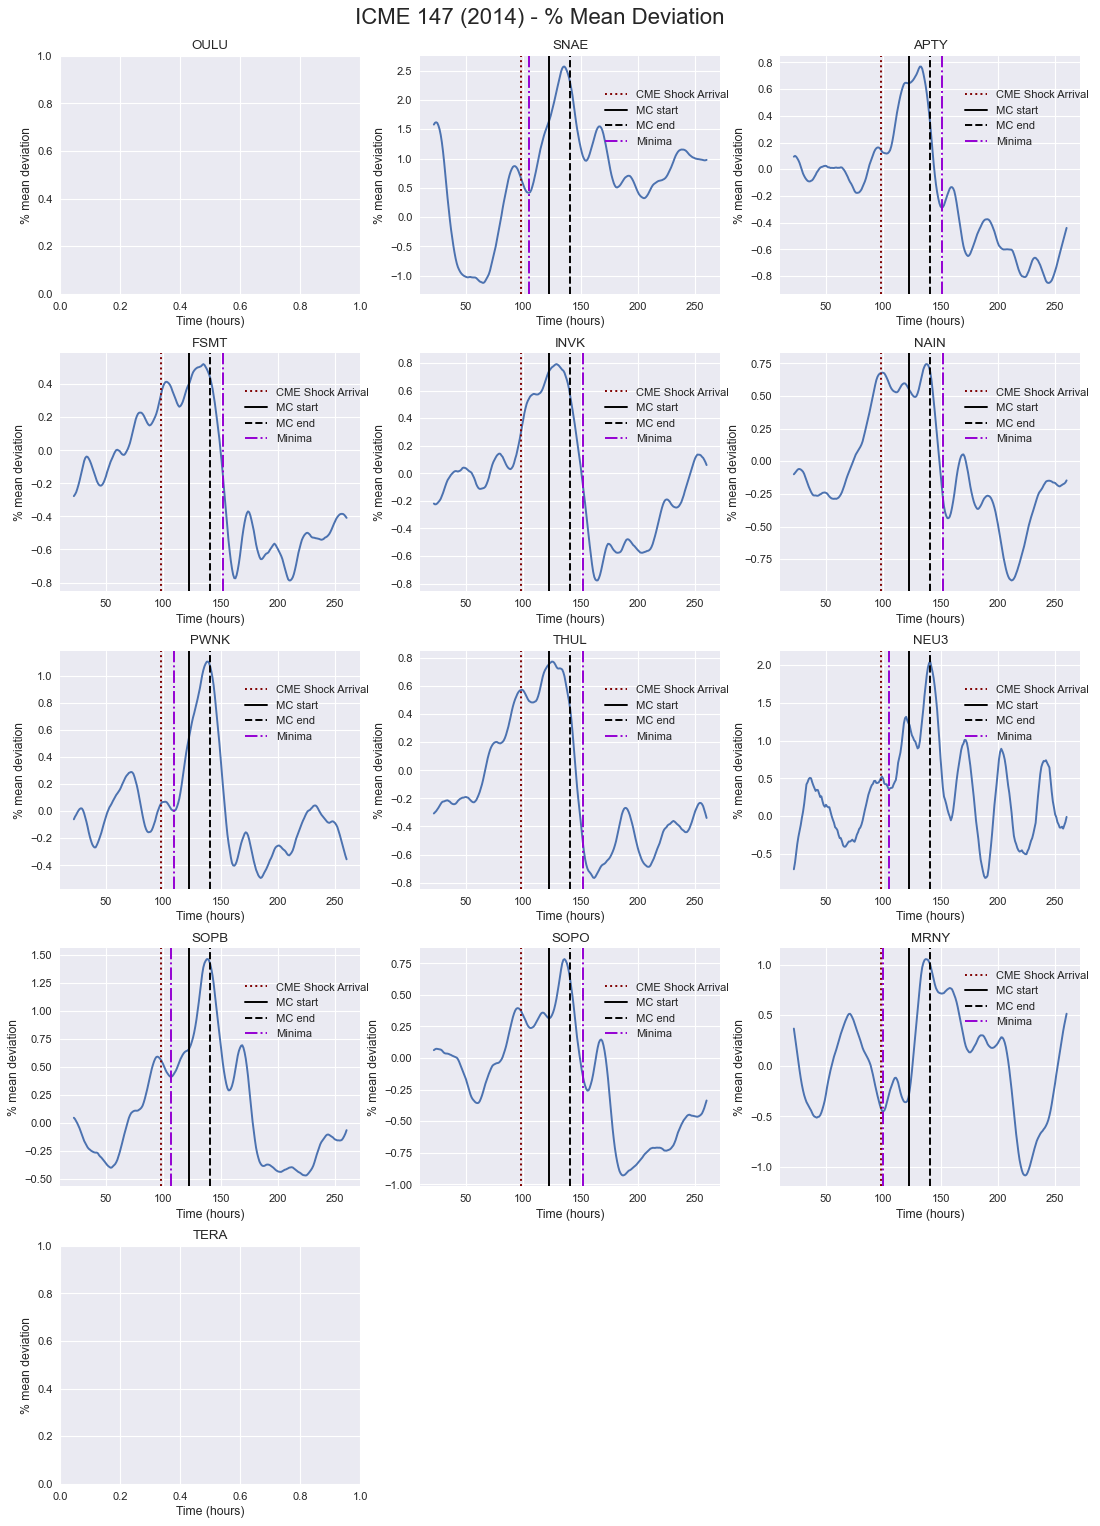

In [24]:
# Plotting all stations in a subplot - ICME 147 %mean dev

# Create a figure environment and define the size using the figsize argument
fig = plt.figure(figsize=(15, 15))

# Cosmetics
plt.style.use('seaborn')


#Add subplots
ax1 = fig.add_subplot(531, title='OULU', xlabel="Time (hours)", ylabel="% mean deviation") 
ax2 = fig.add_subplot(532, title='SNAE', xlabel="Time (hours)", ylabel="% mean deviation") 

ax3 = fig.add_subplot(533, title='APTY', xlabel="Time (hours)", ylabel="% mean deviation") 
ax4 = fig.add_subplot(534, title='FSMT', xlabel="Time (hours)", ylabel="% mean deviation")

ax5 = fig.add_subplot(535, title='INVK', xlabel="Time (hours)", ylabel="% mean deviation") 
ax6 = fig.add_subplot(536, title='NAIN', xlabel="Time (hours)", ylabel="% mean deviation") 

ax7 = fig.add_subplot(537, title='PWNK', xlabel="Time (hours)", ylabel="% mean deviation") 
ax8 = fig.add_subplot(538, title='THUL', xlabel="Time (hours)", ylabel="% mean deviation") 

ax9 = fig.add_subplot(539, title='NEU3', xlabel="Time (hours)", ylabel="% mean deviation") 
ax10 = fig.add_subplot(5,3,10, title='SOPB', xlabel="Time (hours)", ylabel="% mean deviation") 

ax11 = fig.add_subplot(5,3, 11, title='SOPO', xlabel="Time (hours)", ylabel="% mean deviation") 
ax12 = fig.add_subplot(5,3, 12, title='MRNY', xlabel="Time (hours)", ylabel="% mean deviation") 

ax13 = fig.add_subplot(5,3,13, title='TERA', xlabel="Time (hours)", ylabel="% mean deviation") 

fig.subplots_adjust(hspace=0.25, wspace=0.20, left=0.1, right=0.95,
                    bottom=0.01, top=1.20)

shock = 97.67
mcstart = 122.12
mcend = 140.82

#t, pdev1, min1 = allstation_analyze("lowrigall_147.txt",1, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev2, min2 = allstation_analyze("lowrigall_147.txt",2, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev3, min3 = allstation_analyze("lowrigall_147.txt",3, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev4, min4 = allstation_analyze("lowrigall_147.txt",4, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev5, min5 = allstation_analyze("lowrigall_147.txt",5, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev6, min6 = allstation_analyze("lowrigall_147.txt",6, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev7, min7 = allstation_analyze("lowrigall_147.txt",7, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev8, min8 = allstation_analyze("lowrigall_147.txt",8, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev9, min9 = allstation_analyze("lowrigall_147.txt",9, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev10, min10 = allstation_analyze("lowrigall_147.txt",10, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev11, min11 = allstation_analyze("lowrigall_147.txt",11, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
t, pdev12, min12 = allstation_analyze("lowrigall_147.txt",12, 12, "Percentdev_smooth", shock, mcstart, mcend,1)
#t, pdev13, min13 = allstation_analyze("lowrigall_147.txt",13, 12, "Percentdev_smooth", shock, mcstart, mcend,1)


#ax1.plot(t,pdev1)
# 3 time stamps
#ax1.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax1.axvline(mcstart, color='black', label='MC start')
#ax1.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
#ax1.axvline(min1, color='darkviolet', linestyle='-.', label="Minima")
        
ax2.plot(t,pdev2)
# 3 time stamps
ax2.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax2.axvline(mcstart, color='black', label='MC start')
ax2.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax2.axvline(min2, color='darkviolet', linestyle='-.', label="Minima")


ax3.plot(t,pdev3)
# 3 time stamps
ax3.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax3.axvline(mcstart, color='black', label='MC start')
ax3.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax3.axvline(min3, color='darkviolet', linestyle='-.', label="Minima")


ax4.plot(t,pdev4)
# 3 time stamps
ax4.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax4.axvline(mcstart, color='black', label='MC start')
ax4.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax4.axvline(min4, color='darkviolet', linestyle='-.', label="Minima")


ax5.plot(t,pdev5)
# 3 time stamps
ax5.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax5.axvline(mcstart, color='black', label='MC start')
ax5.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax5.axvline(min5, color='darkviolet', linestyle='-.', label="Minima")


ax6.plot(t,pdev6)
# 3 time stamps
ax6.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax6.axvline(mcstart, color='black', label='MC start')
ax6.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax6.axvline(min6, color='darkviolet', linestyle='-.', label="Minima")

ax7.plot(t,pdev7)
# 3 time stamps
ax7.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax7.axvline(mcstart, color='black', label='MC start')
ax7.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax7.axvline(min7, color='darkviolet', linestyle='-.', label="Minima")


ax8.plot(t,pdev8)
# 3 time stamps
ax8.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax8.axvline(mcstart, color='black', label='MC start')
ax8.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax8.axvline(min8, color='darkviolet', linestyle='-.', label="Minima")


ax9.plot(t,pdev9)
# 3 time stamps
ax9.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax9.axvline(mcstart, color='black', label='MC start')
ax9.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax9.axvline(min9, color='darkviolet', linestyle='-.', label="Minima")


ax10.plot(t,pdev10)
# 3 time stamps
ax10.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax10.axvline(mcstart, color='black', label='MC start')
ax10.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax10.axvline(min10, color='darkviolet', linestyle='-.', label="Minima")

ax11.plot(t,pdev11)
# 3 time stamps
ax11.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax11.axvline(mcstart, color='black', label='MC start')
ax11.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax11.axvline(min11, color='darkviolet', linestyle='-.', label="Minima")

ax12.plot(t,pdev12)
# 3 time stamps
ax12.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
ax12.axvline(mcstart, color='black', label='MC start')
ax12.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima 
ax12.axvline(min12, color='darkviolet', linestyle='-.', label="Minima")


#ax13.plot(t,pdev13)
# 3 time stamps
#ax13.axvline(shock, color='maroon', linestyle=':', label='CME Shock Arrival')
#ax13.axvline(mcstart, color='black', label='MC start')
#ax13.axvline(mcend, color='black', linestyle='--', label="MC end")
# Minima #
#ax13.axvline(min13, color='darkviolet', linestyle='-.', label="Minima")

#ax1.legend(loc=(0.6,0.1))
ax2.legend(loc=(0.6,0.6))
ax3.legend(loc=(0.6,0.6))
ax4.legend(loc=(0.6,0.6))
ax5.legend(loc=(0.6,0.6))
ax6.legend(loc=(0.6,0.6))
ax7.legend(loc=(0.6,0.6))
ax8.legend(loc=(0.6,0.6))
ax9.legend(loc=(0.6,0.6))
ax10.legend(loc=(0.6,0.6))
ax11.legend(loc=(0.6,0.6))
ax12.legend(loc=(0.6,0.65))
#ax13.legend(loc=(0.6,0.6))

fig.suptitle("ICME 147 (2014) - % Mean Deviation", fontsize=20, y=1.24) #optional overall figure title
plt.show()

### ICME events yet to be viewed and quality-characterized - 
(please uncomment every line individually to view plots)

In [25]:
# ICME 146 - %mean dev data 

#analyze("lowrigall_146.txt",1, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",2, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",3, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",4, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",5, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",6, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",7, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",8, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",9, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",10, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",11, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",12, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)
#analyze("lowrigall_146.txt",13, 12, "Percentdev_smooth", "ICME 146 (2014)", 97.82, 109.98, 159.15, 1)


In [26]:
# ICME 145 - %mean dev data 2,5,7,9,13 has null values

#analyze("lowrigall_145.txt",1, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)
#analyze("lowrigall_145.txt",3, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)
#analyze("lowrigall_145.txt",4, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)
#analyze("lowrigall_145.txt",6, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)
#analyze("lowrigall_145.txt",8, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)
#analyze("lowrigall_145.txt",10, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)
#analyze("lowrigall_145.txt",11, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)
#analyze("lowrigall_145.txt",12, 12, "Percentdev_smooth", "ICME 145 (2014)", 96.79,112.89,127.25, 1)

Alert!! Forbush Increases lol!!!


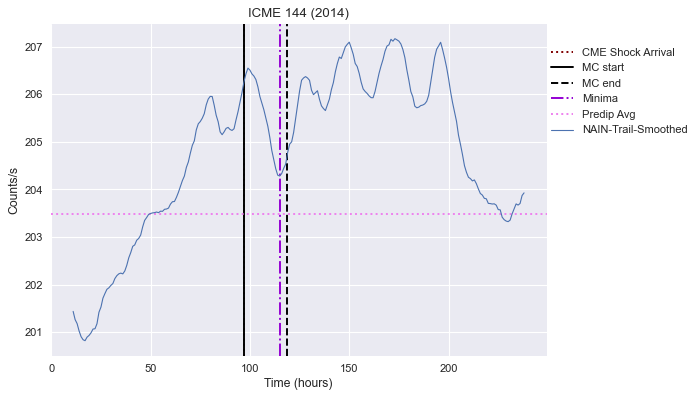

Predip_avg =  203.48723837209312
Local minima =  204.28166666666667
FD magnitude =  -0.7944282945735495
Normalized FDmag =  -0.390406937029079
Location of minima =  (115,)


In [28]:
# ICME 144 - %mean dev data has no null values

#analyze("lowrigall_144.txt",1, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",2, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",3, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",4, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",5, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",6, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
analyze("lowrigall_144.txt",6, 12, "Smoothed", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)     # Example Forbush Increase
#analyze("lowrigall_144.txt",7, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",8, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",9, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",10, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",11, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",12, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)
#analyze("lowrigall_144.txt",13, 12, "Percentdev_smooth", "ICME 144 (2014)", 97.18,97.18, 118.55, 1)

In [28]:
# ICME 143 

#analyze("lowrigall_143.txt",1, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",2, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",3, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",4, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",5, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",6, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",7, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",8, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)#
#analyze("lowrigall_143.txt",9, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",10, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",11, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",12, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)
#analyze("lowrigall_143.txt",13, 12, "Percentdev_smooth", "ICME 143 (2014)", 97.33,118.69,141.20, 1)

Alert!! Forbush Increases lol!!!


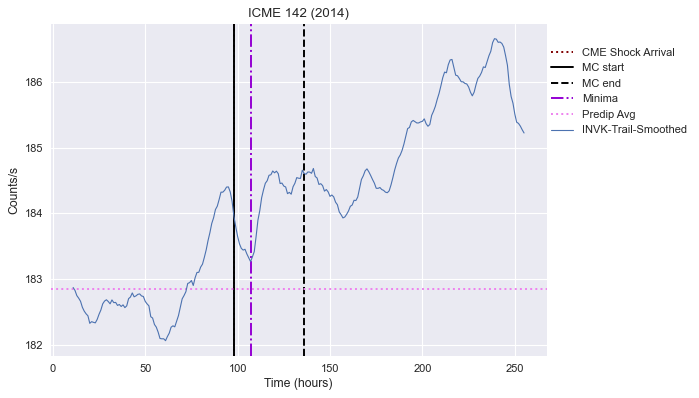

Predip_avg =  182.8406686046512
Local minima =  183.26583333333335
FD magnitude =  -0.42516472868214805
Normalized FDmag =  -0.0023253291071772667
Location of minima =  (107,)


In [29]:
# ICME 142 - %mean dev data 13 has null values

#analyze("lowrigall_142.txt",1, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",2, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",3, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",4, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
analyze("lowrigall_142.txt",5, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)     # Example Forbush Increase
#analyze("lowrigall_142.txt",6, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",7, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",8, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",9, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",10, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",11, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)
#analyze("lowrigall_142.txt",12, 12, "Smoothed", "ICME 142 (2014)", 97.95,97.95,135.87, 1)

In [30]:
# ICME 141 - %mean dev data 9 has null values

#analyze("lowrigall_141.txt",1, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",2, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",3, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",4, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",5, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",6, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",7, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",8, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",10, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",11, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",12, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
#analyze("lowrigall_141.txt",13, 12, "Smoothed", "ICME 141 (2014)", 97.97,110.30,150.40, 1)
